In [ ]:
from google.colab import drive

def mount():
  drive.mount('/content/drive', force_remount=True)

mount()

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


# **1 Load databases and processed results**

## 1.1 Define filepath to databases

In [ ]:
# Raw datasets filepath
WoS_file_path = "drive/MyDrive/Master/Screening/Raw data/wos.csv"
scopus_file_path = "drive/MyDrive/Master/Screening/Raw data/scopus.csv"
ieee_file_path = "drive/MyDrive/Master/Screening/Raw data/ieeexplore.csv"
proQuest_file_path = "drive/MyDrive/Master/Screening/Raw data/proquest.csv"


# Prossed datasets filepath
clean_df_with_gpt_file_path = "drive/MyDrive/Master/Analysis/Processed data from screening/clean_with_gpt_df.csv"
accepted_df_file_path = "drive/MyDrive/Master/Screening/accepted_articles.csv"
tagged_articles_file_path = "drive/MyDrive/Master/Analysis/Processed data from screening/tagged_articles.csv"
author_background_tagged_articles_file_path = "drive/MyDrive/Master/Analysis/Processed data from screening/Author_background_tagged_articles.csv"

## 1.2 Load data into dataframes

In [ ]:
import pandas as pd
import io
import numpy as np

In [55]:
# Load raw data
WoS_df = pd.read_csv(WoS_file_path, sep='\t')
scopus_df = pd.read_csv(scopus_file_path)
ieee_df = pd.read_csv(ieee_file_path, quotechar='"', sep=",")
proQuest_df = pd.read_csv(proQuest_file_path, sep=',')

# Load processed data
clean_df_with_gpt_df = pd.read_csv(clean_df_with_gpt_file_path)
accepted_df = pd.read_csv(accepted_df_file_path)
tagged_articles_df = pd.read_csv(tagged_articles_file_path)
_author_background_tagged_articles_df = pd.read_csv(author_background_tagged_articles_file_path)


In [60]:
# Add exclusion column to author_background_tagged_articles_df and filter away excluded
_author_background_tagged_articles_df["Exclude"] = tagged_articles_df.set_index("ID").loc[_author_background_tagged_articles_df["Article ID (DB id)"], "Exclude"].values
author_background_tagged_articles_df = _author_background_tagged_articles_df[_author_background_tagged_articles_df["Exclude"].isna()]

print("Number of articles in author background analysis:", author_background_tagged_articles_df["Article ID"].unique().size)
print("Number of accpeted articles in tagged articles:", tagged_articles_df[tagged_articles_df["Exclude"].isna()]["ID"].unique().size)

Number of articles in author background analysis: 61
Number of accpeted articles in tagged articles: 61


## 1.3 Cleaning of dataframes

In [ ]:
# Clean Wos dataframe
clean_wos_df = WoS_df.set_index("UT")
clean_wos_df["Origin"] = "WOS"
clean_wos_df.index.name = "ID"

In [7]:
# Clean Scopus dataframe
clean_scopus_df = scopus_df.copy()
clean_scopus_df["ID"] = np.where(pd.isna(clean_scopus_df["DOI"]), scopus_df["EID"], clean_scopus_df["DOI"])
clean_scopus_df = clean_scopus_df.set_index("ID")
clean_scopus_df["Origin"] = "SCOPUS"
clean_scopus_df.index.name = "ID"

In [8]:
# Clean ieee dataframe
clean_ieee_df = ieee_df.copy()
clean_ieee_df["Keywords"] = ieee_df["IEEE Terms"].str.cat(ieee_df["Author Keywords"], sep=";")
clean_ieee_df["ID"] = ieee_df["PDF Link"]
clean_ieee_df = clean_ieee_df.set_index("ID")
clean_ieee_df["Origin"] = "IEEE"
clean_ieee_df.index.name = "ID"

In [9]:
# Clean ProQuest dataframe
clean_proquest_df = proQuest_df.copy()
clean_proquest_df["ID"] = np.where(
    pd.notna(clean_proquest_df["DOI"]), clean_proquest_df["DOI"],
    np.where(
        pd.notna(clean_proquest_df["ISSN"]), clean_proquest_df["ISSN"],
        np.where(
            pd.notna(clean_proquest_df["EISSN"]), clean_proquest_df["EISSN"],
            clean_proquest_df["ISBN"]
        )
    )
)

clean_proquest_df= clean_proquest_df.drop(columns=["ISSN", "EISSN", "ISBN"])
clean_proquest_df = clean_proquest_df.set_index("ID")
clean_proquest_df["Origin"] = "Proquest"
clean_proquest_df.index.name = "ID"

In [10]:
# Rename colums to consistent format in all dataframes when equal information

# WoS dataframe renaming
clean_wos_df.rename(columns={"DOI":"?????"}, inplace=True)
clean_wos_df.rename(columns={
    'ID': '...',
    'AF': 'Authors',
    'TI': 'Title',
    'SO': 'Source Title',
    'PY': 'Publication Year',
    'DT': 'Publication Type',
    'DE': 'Keywords',
    'LA': 'Language',
    'DI': 'DOI',  # Assuming there's a DOI column in the actual data
    'AB': 'Abstract',  # Assuming Abstract was present
    'Z9': 'Cited by',
    'C1': 'Full author information'
}, inplace=True)


# Scopus dataframe renaming
clean_scopus_df.rename(columns={
    'ID': 'ID',
    'Authors': 'Authors',
    'Title': 'Title',
    'Source title': 'Source Title',
    'Year': 'Publication Year',
    'Author Keywords': 'Keywords',
    'DOI': 'DOI',
    'Abstract': 'Abstract',
    'Cited by': 'Cited by',
}, inplace=True)

# IEEE dataframe renaming
clean_ieee_df.rename(columns={
    'ID': 'ID',
    'Authors': 'Authors',
    'Document Title': 'Title',
    'Publication Title': 'Source Title',
    'Publication Year': 'Publication Year',
    'Author Keywords': 'Author Keywords',
    'DOI': 'DOI',
    'Abstract': 'Abstract',
    'Cited by': 'Cited by',  # Add this if citations info exists
}, inplace=True)

# ProQuest dataframe renaming
clean_proquest_df.rename(columns={
    'ID': 'ID',
    'Author': 'Authors',
    'Title': 'Title',
    'Publication': 'Source Title',
    'PubDate': 'Publication Year',
    'DOI': 'DOI',
    'Abstract': 'Abstract',
}, inplace=True)


In [11]:
clean_scopus_df['Author full names']['10.21314/JRMV.2024.002'] # TDO orifion to author and aperpoer group jurnal of whhat type se link tord face

'Caprioli, Sergio (58632917500); Cagliero, Emanuele (58631756500); Crupi, Riccardo (57222250441)'

## 1.4 Merge cleaned dataframes

In [12]:
all_columns = set(clean_wos_df.columns).union(clean_scopus_df.columns, clean_ieee_df.columns, clean_proquest_df.columns)
clean_wos_df = clean_wos_df.reindex(columns=all_columns)
clean_scopus_df = clean_scopus_df.reindex(columns=all_columns)
clean_ieee_df = clean_ieee_df.reindex(columns=all_columns)
clean_proquest_df = clean_proquest_df.reindex(columns=all_columns)
clean_df = pd.concat([clean_wos_df, clean_scopus_df, clean_ieee_df, clean_proquest_df]).reset_index()
clean_df

,ID,Subtitle,End Page,IS,Title,PU,SourceType,Funding Information,Author full names,PageRange,...,DOI,FX,TC,Cited by,WC,BN,BP,IEEE Terms,Article Citation Count,PI
0,WOS:000610728400001,NaN,NaN,1,Global Stock Selection with Hidden Markov Model,NaN,NaN,NaN,NaN,NaN,...,10.3390/risks9010009,NaN,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,WOS:000456228800001,NaN,NaN,NaN,High-order Hidden Markov Model for trend predi...,NaN,NaN,NaN,NaN,NaN,...,10.1016/j.physa.2018.10.053,NaN,41.0,44.0,NaN,NaN,1.0,NaN,NaN,NaN
2,WOS:001061639000001,NaN,NaN,NaN,COVID-19 and commodity effects monitoring usin...,NaN,NaN,NaN,NaN,NaN,...,10.1016/j.sciaf.2023.e01856,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,WOS:000980522800001,NaN,NaN,NaN,An algorithmic trading system based on a stack...,NaN,NaN,NaN,NaN,NaN,...,10.1016/j.gfj.2023.100825,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
4,WOS:000773704100006,NaN,NaN,NaN,Research on HMM-Based Efficient Stock Price Pr...,NaN,NaN,NaN,NaN,NaN,...,10.1155/2022/8124149,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,07474938,NaN,NaN,NaN,Classical and Bayesian Analysis of Univariate ...,NaN,Scholarly Journals,NaN,NaN,335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551,https://doi.org/10.3389/frai.2021.732805,NaN,NaN,NaN,Implementation of a Commitment Machine for an ...,NaN,Undefined,NaN,NaN,732805,...,https://doi.org/10.3389/frai.2021.732805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,https://doi.org/10.1016/j.jclepro.2020.125140,NaN,NaN,NaN,The impact of the global stock and energy mark...,NaN,Undefined,NaN,NaN,NaN,...,https://doi.org/10.1016/j.jclepro.2020.125140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,0167-9473,NaN,NaN,NaN,Bayesian analysis of a change-point in exponen...,NaN,Undefined,NaN,NaN,195-208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Normalize DOI
clean_df["DOI"] = clean_df["DOI"].str.lower()
clean_df["DOI"] = clean_df["DOI"].str.replace("https://doi.org/", "")

# Separate NaN DOIs
nan_doi_df = clean_df[clean_df['DOI'].isna()]
non_nan_doi_df = clean_df[clean_df['DOI'].notna()]

# Group non-NaN DOIs and fill with values from all matching rows
grouped_non_nan = non_nan_doi_df.reset_index().groupby(['DOI'], as_index=False).first().set_index("index").sort_index()

# Combine the grouped non-NaN DOIs with the NaN DOI rows
merged_df = pd.concat([grouped_non_nan, nan_doi_df], ignore_index=True)

# Display
merged_df

,DOI,ID,Subtitle,End Page,IS,Title,PU,SourceType,Funding Information,Author full names,...,Reference Count,FX,TC,Cited by,WC,BN,BP,IEEE Terms,Article Citation Count,PI
0,10.3390/risks9010009,WOS:000610728400001,NaN,NaN,1,Global Stock Selection with Hidden Markov Model,NaN,Scholarly Journals,None,"Nguyen, Nguyet (56496160300); Nguyen, Dung (57...",...,NaN,NaN,6.0,6.0,NaN,NaN,NaN,None,NaN,NaN
1,10.1016/j.physa.2018.10.053,WOS:000456228800001,NaN,NaN,None,High-order Hidden Markov Model for trend predi...,NaN,None,None,"Zhang, Mengqi (57204575067); Jiang, Xin (57191...",...,NaN,NaN,41.0,44.0,NaN,NaN,1.0,None,NaN,NaN
2,10.1016/j.sciaf.2023.e01856,WOS:001061639000001,NaN,NaN,None,COVID-19 and commodity effects monitoring usin...,NaN,None,None,"Shah, Yasir (57197873733); Liu, Yumin (3651903...",...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,None,NaN,NaN
3,10.1016/j.gfj.2023.100825,WOS:000980522800001,NaN,NaN,None,An algorithmic trading system based on a stack...,NaN,None,None,"Fereydooni, Ali (58107239800); Mahootchi, Maso...",...,NaN,NaN,5.0,5.0,NaN,NaN,NaN,None,NaN,NaN
4,10.1155/2022/8124149,WOS:000773704100006,NaN,NaN,None,Research on HMM-Based Efficient Stock Price Pr...,NaN,Scholarly Journals,None,"Su, Zhi (57191838693); Yi, Bo (57547140600)",...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,NaN,978-1-109-52503-8,NaN,NaN,NaN,Variance-based clustering methods and higher o...,NaN,Dissertations & Theses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,02522667,NaN,NaN,NaN,Forecasting classification of operating perfor...,NaN,Scholarly Journals,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,NaN,0038092X,NaN,NaN,NaN,Probabilistic forecasting of the solar irradia...,NaN,Scholarly Journals,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,NaN,07474938,NaN,NaN,NaN,Classical and Bayesian Analysis of Univariate ...,NaN,Scholarly Journals,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Show title dupes
merged_df[merged_df["Title"].duplicated(keep=False)].sort_values("Title")[["Title", "Authors", "DOI", "Origin"]]

,Title,Authors,DOI,Origin
318,A stacked generalization system for automated ...,"Petropoulos, Anastasios; Chatzis, Sotirios P; ...",NaN,Proquest
109,A stacked generalization system for automated ...,"Petropoulos, Anastasios; Chatzis, Sotirios P.;...",10.1016/j.eswa.2017.08.011,WOS
235,A stock selection strategy using fuzzy neural ...,Wong F.S.; Wang P.Z.; Teh H.H.,10.1007/bf00436283,SCOPUS
234,A stock selection strategy using fuzzy neural ...,Wong F.S.; Wang P.Z.,10.1016/0925-2312(91)90026-8,SCOPUS
11,Adoption of deep learning Markov model combine...,"Liu, Shangyi; Khadidos, Adil Omar; Abdulrazzqa...",10.2478/amns.2021.2.00065,WOS
13,Adoption of deep learning Markov model combine...,"Li, Liangxiong; Muwafak, Bishr Muhamed",10.2478/amns.2021.1.00085,WOS
221,Adoption of deep learning Markov model combine...,Li L.; Muwafak B.M.,10.2478/amns.2021.2.00112,SCOPUS
334,Bayesian analysis of a change-point in exponen...,"Lee, Ch-B",NaN,Proquest
54,Bayesian analysis of a change-point in exponen...,"Lee, CB",10.1016/s0167-9473(98)00009-7,WOS
316,Negation scope detection in sentiment analysis...,"Pröllochs, Nicolas; Feuerriegel, Stefan; Neuma...",NaN,Proquest


In [16]:
# Do the same for title
merged_df = merged_df.reset_index().groupby(['Title'], as_index=False).first().set_index("ID")
merged_df = merged_df.copy()
merged_df

,Title,index,DOI,Subtitle,End Page,IS,PU,SourceType,Funding Information,Author full names,...,Reference Count,FX,TC,Cited by,WC,BN,BP,IEEE Terms,Article Citation Count,PI
ID,,,,,,,,,,,,,,,,,,,,,
WOS:000779594700001,<i>DL-GuesS</i>: Deep Learning and Sentiment A...,14,10.1109/access.2022.3163305,NaN,35409.0,None,NaN,Scholarly Journals,None,"Parekh, Raj (58343924800); Patel, Nisarg P. (5...",...,31.0,NaN,25.0,25.0,NaN,NaN,35398.0,Cryptography;Predictive models;Bitcoin;Hidden ...,36.0,NaN
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8408721,A Bayesian Learning Method for Financial Time-...,239,10.1109/access.2018.2853998,NaN,38966.0,None,NaN,None,National Natural Science Foundation of China(g...,None,...,46.0,NaN,NaN,NaN,NaN,NaN,NaN,Bayes methods;Biological system modeling;Numer...,13.0,NaN
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9366736,A Bayesian Regularized Neural Network for Anal...,262,10.1109/access.2021.3063243,NaN,38000.0,None,NaN,None,Taif University Researchers Supporting Project...,None,...,39.0,NaN,NaN,NaN,NaN,NaN,NaN,Bitcoin;Predictive models;Blockchain;Market re...,16.0,NaN
WOS:000889065800003,A Bayesian analysis based on multivariate stoc...,61,10.1007/s10878-022-00936-0,NaN,NaN,1,NaN,Scholarly Journals,None,None,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,None,NaN,NaN
WOS:000863229400001,A Bayesian-based classification framework for ...,104,10.1007/s11227-022-04834-4,NaN,NaN,4,NaN,Scholarly Journals,None,"Dezhkam, Arsalan (54897977700); Manzuri, Moham...",...,NaN,NaN,7.0,7.0,NaN,NaN,4622.0,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOS:000891788100011,Volatility index prediction based on a hybrid ...,135,10.1016/j.eswa.2022.119184,NaN,NaN,None,NaN,None,None,"Tian, Chaonan (57793330400); Niu, Tong (571935...",...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,None,NaN,NaN
10.1109/LRA.2021.3070308,Volumetric occupancy mapping with probabilisti...,210,10.1109/lra.2021.3070308,NaN,NaN,None,NaN,None,None,"Popovic, Marija (57195415517); Thomas, Florian...",...,NaN,NaN,NaN,10.0,NaN,NaN,NaN,None,NaN,NaN
https://doi.org/10.3390/signals1010001,Welcome to SIGNALS: A New Open-Access Scientif...,305,10.3390/signals1010001,NaN,NaN,None,NaN,Scholarly Journals,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


## 1.4 Dataframe with tacgged article and all possbile columns

In [17]:
db_ids = set(merged_df.index.unique())
notion_ids = set(tagged_articles_df["ID (tekst)"].unique())
missing_ids = notion_ids - db_ids
assert not missing_ids, f"Missing IDs: {missing_ids}"

In [18]:
tagged_articles_all_info_all_columns_df = pd.merge(tagged_articles_df.set_index("ID (tekst)"), merged_df, how="inner", right_index=True, left_index=True, suffixes=('_notion', '_db'))
tagged_articles_all_info_all_columns_df

,Assessed by,Status,ID,Double checked by,Title_notion,Link_notion,File,Exclude,Model input,Horizon,...,Reference Count,FX,TC,Cited by,WC,BN,BP,IEEE Terms,Article Citation Count,PI
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9448324,Tord/Sivert,Assessed,https://ieeexplore.ieee.org/stamp/stamp.jsp?ar...,NaN,A Hybrid Approach of Bayesian Structural Time ...,https://doi.org/10.1109/tcss.2021.3073964,A_Hybrid_Approach_of_Bayesian_Structural_Time_...,Exclude,"History, Sentiment",1 day,...,50.0,NaN,NaN,NaN,NaN,NaN,NaN,Predictive models;Mathematical model;Data mode...,16.0,NaN
10.1016/j.techfore.2023.122719,Tord/Sivert,Assessed,10.1016/j.techfore.2023.122719 (https://www.no...,NaN,A granular machine learning framework for fore...,https://doi.org/10.1016/j.techfore.2023.122719,1-s2.0-S0040162523004043-main.pdf,Exclude,"History, Technical",1 minute,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,None,NaN,NaN
https://doi.org/10.1088/1742-6596/2287/1/012018,Tord/Sivert,Assessed,https://doi.org/10.1088/1742-6596/2287/1/01201...,NaN,A Machine Learning Model for Healthcare Stocks...,https://doi.org/10.1088/1742-6596/2287/1/012018,Jariyapan_2022_J._Phys.__Conf._Ser._2287_01201...,Exclude,"History, Sentiment",1 month,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
WOS:000737351200001,Tord,Assessed,WOS:000737351200001 (https://www.notion.so/WOS...,Tord Johan Espe,Predicting Volatility Index According to Techn...,https://doi.org/10.3390/su132414011,sustainability-13-14011-v2.pdf,NaN,"History, Technical",1 day,...,NaN,NaN,10.0,10.0,NaN,NaN,NaN,None,NaN,NaN
WOS:000873142500002,Tord,Assessed,WOS:000873142500002 (https://www.notion.so/WOS...,Tord Johan Espe,Encoded Value-at-Risk: A machine learning appr...,https://doi.org/10.1016/j.matcom.2022.07.015,1-s2.0-S0378475422003172-main.pdf,NaN,"History, Technical",1 day,...,NaN,NaN,5.0,5.0,NaN,NaN,500.0,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1016/j.aej.2023.08.025,Sivert,In progress,10.1016/j.aej.2023.08.025 (https://www.notion....,NaN,Analysis of bitcoin prices using a heavy-taile...,https://doi.org/10.1016/j.aej.2023.08.025,1-s2.0-S1110016823007068-main.pdf,Exclude,"Environment, History",NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,None,NaN,NaN
WOS:000729809800019,Kristoffer,In progress,WOS:000729809800019 (https://www.notion.so/WOS...,NaN,Dynamic forecasting performance and liquidity ...,https://doi.org/10.1016/j.physa.2021.126546,1-s2.0-S0378437121008190-main.pdf,Exclude,History,NaN,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,None,NaN,NaN
WOS:000398964300009,Kristoffer,In progress,WOS:000398964300009 (https://www.notion.so/WOS...,NaN,Bayesian regularisation neural network based o...,https://doi.org/10.1080/00207543.2016.1237785,Bayesian_regularisation_neural_network_based_o...,Exclude,"History, Technical",1 day,...,NaN,NaN,44.0,46.0,NaN,NaN,2266.0,None,NaN,NaN
10.17586/2226-1494-2023-23-1-105-111,Kristoffer,In progress,10.17586/2226-1494-2023-23-1-105-111 (https://...,NaN,Probabilistic criteria for time-series predict...,https://doi.org/10.17586/2226-1494-2023-23-1-1...,21744.pdf,Exclude,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,None,NaN,NaN


# **2 Analysis**

## 2.1 Results per database

In [19]:
# Find number of results per database source

wos_results_before_screening = len(clean_wos_df)
scopus_results_before_screening = len(clean_scopus_df)
ieee_results_before_screening = len(clean_ieee_df)
proquest_results_before_screening = len(clean_proquest_df)
total_sample_size_before_screening = wos_results_before_screening + scopus_results_before_screening + ieee_results_before_screening + proquest_results_before_screening

print("Number of results before screening:")
print(f"Number of results in WoS: {wos_results_before_screening}")
print(f"Number of results in Scopus: {scopus_results_before_screening}")
print(f"Number of results in IEEE: {ieee_results_before_screening}")
print(f"Number of results in ProQuest: {proquest_results_before_screening}")
print(f"Total number of results: {total_sample_size_before_screening}")


Number of results before screening:
Number of results in WoS: 158
Number of results in Scopus: 213
Number of results in IEEE: 76
Number of results in ProQuest: 108
Total number of results: 555


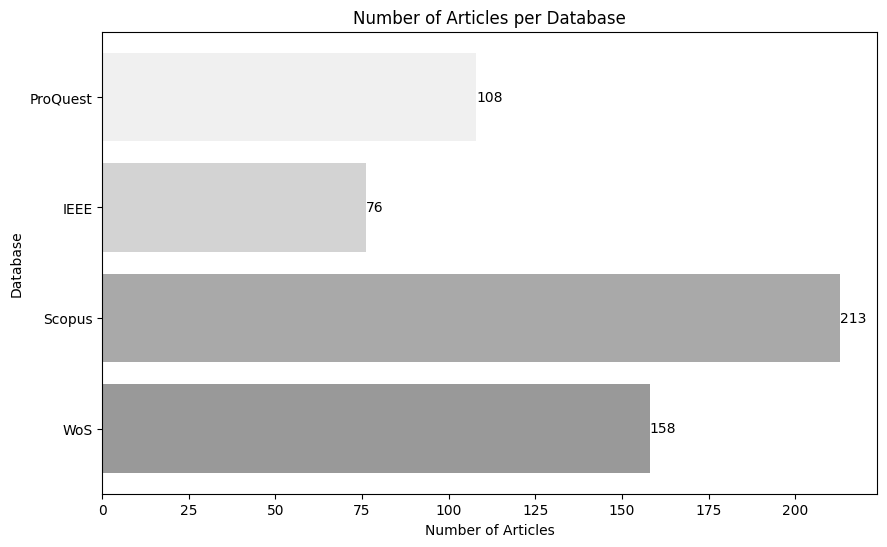

In [20]:
# Bar chart of total sample size of articles per database before cleaning and screening
# prompt: make a horizontal bar chart of number of articles per database in grey tones. make sure to show axis and add number on top of the bars

import matplotlib.pyplot as plt

# Data for the chart
databases = ['WoS', 'Scopus', 'IEEE', 'ProQuest']
results = [wos_results_before_screening, scopus_results_before_screening, ieee_results_before_screening, proquest_results_before_screening]
colors = ['#999999', '#A9A9A9', '#D3D3D3', '#F0F0F0']

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(databases, results, color=colors)

# Add numbers on top of the bars
for bar in bars:
  width = bar.get_width()
  plt.text(width, bar.get_y() + bar.get_height()/2, str(int(width)), ha='left', va='center')

# Add labels and title
plt.xlabel('Number of Articles')
plt.ylabel('Database')
plt.title('Number of Articles per Database')

# Show the chart
plt.show()


# TODO Add second bare of nuber pased screening 1 and 2


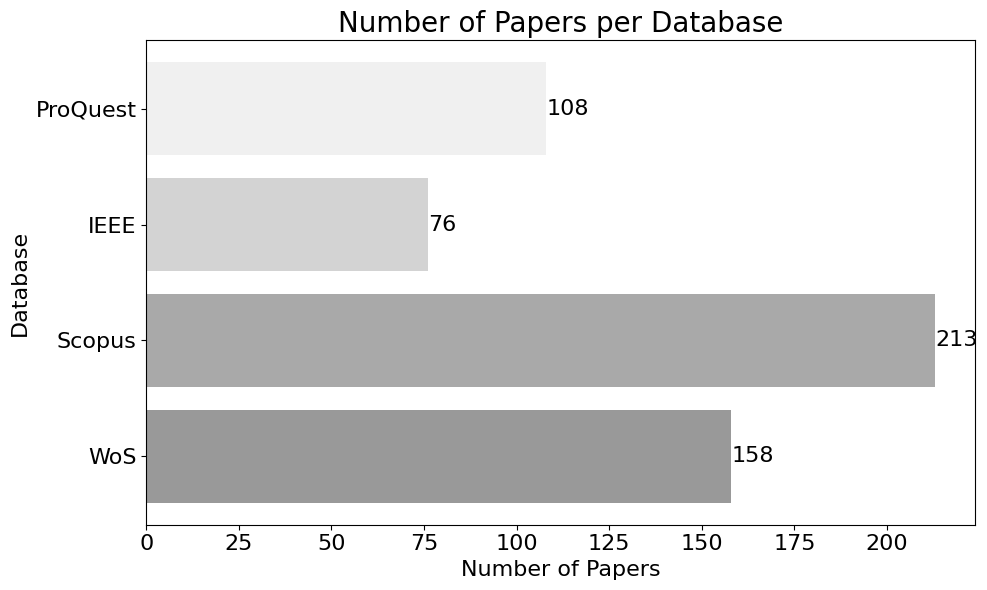

In [21]:
import matplotlib.pyplot as plt

# Data for the chart
databases = ['WoS', 'Scopus', 'IEEE', 'ProQuest']
results = [wos_results_before_screening, scopus_results_before_screening, ieee_results_before_screening, proquest_results_before_screening]
colors = ['#999999', '#A9A9A9', '#D3D3D3', '#F0F0F0']

# Font size parameters for an academic paper
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 16
text_fontsize = 16

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
bars = plt.barh(databases, results, color=colors)

# Add numbers on top of the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, str(int(width)),
             ha='left', va='center', fontsize=text_fontsize)

# Add labels and title with larger font sizes
plt.xlabel('Number of Papers', fontsize=label_fontsize)
plt.ylabel('Database', fontsize=label_fontsize)
plt.title('Number of Papers per Database', fontsize=title_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Show the chart
plt.tight_layout()  # Ensures everything fits well
plt.show()


## 2.2 Funnel

In [22]:
# Number of articles in all steps of the screening funnel

# prompt: define varaibles for number of the total sample size before screening (total_sample_size_before_screening), cleaned in terms of removed duplicates bofore screening (clean_df_with_gpt_df),
# after fist screening (accepted_df) and affter second screening (tagged_articles_df)

# total_sample_size_before_screening
total_sample_size_cleaned_before_screening = len(clean_df_with_gpt_df)
total_sample_size_after_first_screening = len(accepted_df)
total_sample_size_after_second_screening = len(tagged_articles_df)


In [23]:
pip install pysankey # TODO USE THIS INSTEAD?

In [24]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [25]:
# Calculate remaining counts
removed_duplicates = total_sample_size_before_screening - total_sample_size_cleaned_before_screening
removed_after_first_screening = total_sample_size_cleaned_before_screening - total_sample_size_after_first_screening
removed_after_second_screening = total_sample_size_after_first_screening - total_sample_size_after_second_screening

# Define links as per the steps of your funnel, including total counts in the labels
links = [
    # Step 1: Total Sample Size -> No Duplicates and Removed Duplicates
    {'source': f'Total Sample Size ({total_sample_size_before_screening})',
     'target': f'No Duplicates ({total_sample_size_cleaned_before_screening})',
     'value': total_sample_size_cleaned_before_screening},
    {'source': f'Total Sample Size ({total_sample_size_before_screening})',
     'target': f'Removed Duplicates ({removed_duplicates})',
     'value': removed_duplicates},

    # Step 2: No Duplicates -> Passed First Screening and Removed After First Screening
    {'source': f'No Duplicates ({total_sample_size_cleaned_before_screening})',
     'target': f'Passed First Screening ({total_sample_size_after_first_screening})',
     'value': total_sample_size_after_first_screening},
    {'source': f'No Duplicates ({total_sample_size_cleaned_before_screening})',
     'target': f'Removed After First Screening ({removed_after_first_screening})',
     'value': removed_after_first_screening},

    # Step 3: Passed First Screening -> Passed Second Screening and Removed After Second Screening
    {'source': f'Passed First Screening ({total_sample_size_after_first_screening})',
     'target': f'Passed Second Screening ({total_sample_size_after_second_screening})',
     'value': total_sample_size_after_second_screening},
    {'source': f'Passed First Screening ({total_sample_size_after_first_screening})',
     'target': f'Removed After Second Screening ({removed_after_second_screening})',
     'value': removed_after_second_screening}
]

# Convert the links to a DataFrame
df = pd.DataFrame(links)

# Create unique nodes from sources and targets
nodes = np.unique(df[["source", "target"]], axis=None)
nodes = pd.Series(index=nodes, data=range(len(nodes)))  # Assign indices to nodes

# Define grey tones for nodes and links
node_color = ['#aaaaaa'] * len(nodes)  # Slightly darker grey for nodes
link_color = ['#bbbbbb'] * len(df)     # Light grey for links

# Create the Sankey diagram using Plotly
fig = go.Figure(
    go.Sankey(
        node={
            "label": nodes.index.tolist(),  # Node labels with total counts in parentheses
            "color": node_color,            # Set grey color for nodes
            "pad": 15,                      # Padding between nodes for readability
            "thickness": 20,                # Thickness of nodes
        },
        link={
            "source": nodes.loc[df["source"]],  # Source nodes
            "target": nodes.loc[df["target"]],  # Target nodes
            "value": df["value"],               # Flow values
            "color": link_color,                # Set grey color for links
        },
    )
)

# Set the title and layout with text aligned to the right
fig.update_layout(
    title_text="Flow Chart of Cleaning and Screening Process",
    font_size=12,
    font_color="#333333",  # Darker grey for font color
    title_x=0.5,  # Center the title
    title_font_size=20,
    title_font_color="#333333"
)

# Display the figure
fig.show()

## 2.3 Descriptive statistics

### 2.3.1 Scientific productivity (by year)



In [26]:
tagged_articles_all_info_df = tagged_articles_all_info_all_columns_df
tagged_articles_all_info_df

,Assessed by,Status,ID,Double checked by,Title_notion,Link_notion,File,Exclude,Model input,Horizon,...,Reference Count,FX,TC,Cited by,WC,BN,BP,IEEE Terms,Article Citation Count,PI
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9448324,Tord/Sivert,Assessed,https://ieeexplore.ieee.org/stamp/stamp.jsp?ar...,NaN,A Hybrid Approach of Bayesian Structural Time ...,https://doi.org/10.1109/tcss.2021.3073964,A_Hybrid_Approach_of_Bayesian_Structural_Time_...,Exclude,"History, Sentiment",1 day,...,50.0,NaN,NaN,NaN,NaN,NaN,NaN,Predictive models;Mathematical model;Data mode...,16.0,NaN
10.1016/j.techfore.2023.122719,Tord/Sivert,Assessed,10.1016/j.techfore.2023.122719 (https://www.no...,NaN,A granular machine learning framework for fore...,https://doi.org/10.1016/j.techfore.2023.122719,1-s2.0-S0040162523004043-main.pdf,Exclude,"History, Technical",1 minute,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,None,NaN,NaN
https://doi.org/10.1088/1742-6596/2287/1/012018,Tord/Sivert,Assessed,https://doi.org/10.1088/1742-6596/2287/1/01201...,NaN,A Machine Learning Model for Healthcare Stocks...,https://doi.org/10.1088/1742-6596/2287/1/012018,Jariyapan_2022_J._Phys.__Conf._Ser._2287_01201...,Exclude,"History, Sentiment",1 month,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
WOS:000737351200001,Tord,Assessed,WOS:000737351200001 (https://www.notion.so/WOS...,Tord Johan Espe,Predicting Volatility Index According to Techn...,https://doi.org/10.3390/su132414011,sustainability-13-14011-v2.pdf,NaN,"History, Technical",1 day,...,NaN,NaN,10.0,10.0,NaN,NaN,NaN,None,NaN,NaN
WOS:000873142500002,Tord,Assessed,WOS:000873142500002 (https://www.notion.so/WOS...,Tord Johan Espe,Encoded Value-at-Risk: A machine learning appr...,https://doi.org/10.1016/j.matcom.2022.07.015,1-s2.0-S0378475422003172-main.pdf,NaN,"History, Technical",1 day,...,NaN,NaN,5.0,5.0,NaN,NaN,500.0,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1016/j.aej.2023.08.025,Sivert,In progress,10.1016/j.aej.2023.08.025 (https://www.notion....,NaN,Analysis of bitcoin prices using a heavy-taile...,https://doi.org/10.1016/j.aej.2023.08.025,1-s2.0-S1110016823007068-main.pdf,Exclude,"Environment, History",NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,None,NaN,NaN
WOS:000729809800019,Kristoffer,In progress,WOS:000729809800019 (https://www.notion.so/WOS...,NaN,Dynamic forecasting performance and liquidity ...,https://doi.org/10.1016/j.physa.2021.126546,1-s2.0-S0378437121008190-main.pdf,Exclude,History,NaN,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,None,NaN,NaN
WOS:000398964300009,Kristoffer,In progress,WOS:000398964300009 (https://www.notion.so/WOS...,NaN,Bayesian regularisation neural network based o...,https://doi.org/10.1080/00207543.2016.1237785,Bayesian_regularisation_neural_network_based_o...,Exclude,"History, Technical",1 day,...,NaN,NaN,44.0,46.0,NaN,NaN,2266.0,None,NaN,NaN
10.17586/2226-1494-2023-23-1-105-111,Kristoffer,In progress,10.17586/2226-1494-2023-23-1-105-111 (https://...,NaN,Probabilistic criteria for time-series predict...,https://doi.org/10.17586/2226-1494-2023-23-1-1...,21744.pdf,Exclude,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,None,NaN,NaN


In [27]:
assert tagged_articles_all_info_df["Publication Year"].notna().all()

In [28]:
# Convert publication year to string and read 4 first characters
tagged_articles_all_info_df["Publication Year (Year only)"] = tagged_articles_all_info_df["Publication Year"].astype(str).str[:4]
assert tagged_articles_all_info_df["Publication Year (Year only)"].notna().all()

# Convert to int
tagged_articles_all_info_df["Publication Year (Year only)"] = tagged_articles_all_info_df["Publication Year (Year only)"].astype(int)
assert tagged_articles_all_info_df["Publication Year (Year only)"].notna().all()

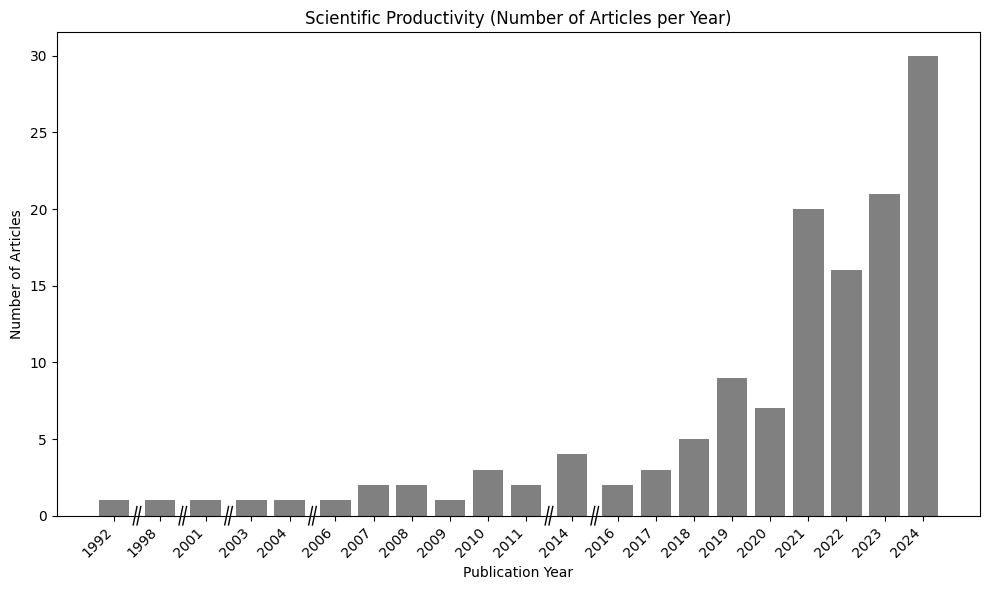

In [29]:
# Get the publication year counts
publication_years = tagged_articles_all_info_df['Publication Year (Year only)'].value_counts().sort_index()

# Get the list of years with publications and their counts
years_with_publications = publication_years.index.tolist()
counts = publication_years.values.tolist()

# Initialize lists for positions and labels
positions = []
x_labels = []
current_position = 0
gap_positions = []

# Loop through the years to handle missing years
gap_size = 0.1
for i, year in enumerate(years_with_publications):
    if i > 0:
        gap = year - years_with_publications[i - 1]
        if gap > 1:
            # Insert a small gap for gaps greater than 1 year
            current_position += gap_size
            gap_positions.append(current_position)  # Record the gap position
            current_position += gap_size

    # Add the current year
    positions.append(current_position)
    x_labels.append(str(int(year)))
    current_position += 1  # Increment position for the next bar

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(positions, counts, color='gray', width=0.8)

# Set the x-ticks to match the positions and labels
ax.set_xticks(positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Draw '//' at the gap positions
for gap_pos in gap_positions:
    # Coordinates for the '//' symbol
    y = -max(counts) * 0.02  # Slightly below the x-axis
    dy = max(counts) * 0.04  # Length of the slashes

    # Draw two slashes to represent the '//' symbol
    ax.plot([gap_pos - 0.5 - gap_size, gap_pos - 0.5], [y, y + dy], color='black', clip_on=False, linewidth=1)
    ax.plot([gap_pos - 0.5, gap_pos - 0.5 + gap_size], [y, y + dy], color='black', clip_on=False, linewidth=1)

# Add labels and title
ax.set_xlabel('Publication Year')
ax.set_ylabel('Number of Articles')
ax.set_title('Scientific Productivity (Number of Articles per Year)')

# Force y axis to start at 0
ax.set_ylim(bottom=0)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()
plt.show()

### 2.3.2 Type of prediction (Short term, long term etc. )


### 2.3.3 By country


### 2.3.4 By asset by market

In [30]:
# pip install plotly

In [31]:
category_file_path = "drive/MyDrive/Master/Analysis/Processed data from screening/tagged_articles.csv"
category_df = pd.read_csv(category_file_path)
category_df = category_df[["Type of asset", "Specific asset"]]
category_df

,Type of asset,Specific asset
0,Stocks,Indian Stocks
1,"Commodities, Cryptocurrency, Forex, Stock indices","Bitcoin (BTC), Crude oil, Dow Jones Industrial..."
2,Stocks,Healthcare (American) sector Stocks
3,Volatility index,VIX
4,"Portfolio, Stocks",Frankfurt Stock Exchange(FSE) stocks portfolio...
...,...,...
128,Cryptocurrency,NaN
129,Stock indices,NaN
130,Stock indices,NaN
131,Stocks,NaN


In [32]:
# define a hierarchy

data = {
    'category': ['Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities',
                 'Currencies','Currencies','Currencies','Currencies','Currencies', 'Currencies',
                 'Commodities','Commodities',
                 'Derivatives','Derivatives','Derivatives','Derivatives','Derivatives','Derivatives','Derivatives','Derivatives',
                 'Bonds', 'Bonds'],
    'subcategory': ['Stock Indices', "Stock Indices", "Stock Indices", "Stock Indices", "Stock Indices", "Stock Indices", 'Stocks', 'Stocks', 'Stocks', 'Stocks', 'Stocks',
                    'Forex Pairs', 'Forex Pairs', 'Forex Pairs', "Cryptocurrencies", "Cryptocurrencies", "Cryptocurrencies",
                     "Metals", "Oil",
                    "Options", "Options", "Swaps", "Futures", "Futures", "Volatility Indices", "Volatility Indices", "Volatility Indices",
                    "Government Bonds", "Corporate Bonds"],
    'subsubcategory': ["S&P 500", "DJI", "NASDAQ", "Asian Indices", "European Indices", "Other Indices",
                       "American", "Asian", "European", "Sector-Based", "Other",
                       "USD/European", "USD/Asian", "Other Pairs",
                       "Bitcoin", "Ethereum", "Other Cryptocurrencies",
                       "Metals",
                       "Oil",
                       "S&P 500 Options", "Other Options",
                       "Swaps",
                       "Equity Futures", "Commodity Futures",
                       "VIX", "Commodity Volatility Indices", "Other Volatility Indices",
                       "Government Bonds",
                       "Corporate Bonds"
                       ],
}
print(len(data["category"]), len(data["subcategory"]), len(data["subsubcategory"]))

29 29 29


In [33]:
#map every asset to a subsubcategory:

subsub_category_mapping = {
    "S&P 500": ["S&P 500 stock index", "S&P 500 Equity Index", "s&p500 equity index", "spx", "s&p 500", "(sp) u.s. s&p 500"],

    "DJI": ["Dow Jones Industrial Average", "Dow Jones", "DJI", "dow jones industrial average (dow jones)", "dow jones industrial", "dow jones (usa)"],

    "NASDAQ": ["nasdaq composite (nasdaq)", "nasdaq", "national association of securities dealers automated quotations (nasdaq)", "nasdaq composite (usa)"],

    "Asian Indices": ["Nikkei 225", "Hang Seng Index (HSI)", "Shanghai Composite", "KOSPI 200 Index", "Stock Exchange Thailand (SET)", "CSI 300", "nikkei 225 index",
                      'sri lankan stock market index(aspi)', "n225", "kospi 200 index", "second-board market of shenzhen stock exchange (szse)", "(nik) japanese nikkei 225",
                      "taiwan weighted stock index", "bse 30 sensex (india)", "hang seng (china)", "nikkei 225 (japan)", "shangai composite (china)"],

    "European Indices": ["NASDAQ Nordic Helsinki exchange assets", "FTSE 100", "DAX performance-index", "CAC 40", "IBEX (Spanish Index)",
                         "PX (Czech Republic)", "OMXR (Latvia)", "OMXT (Estonia)", "OMXV (Lithuania)", "SOFIX (Bulgaria)", "WIG20 (Poland index)", "SMI", "ftse",
                         "stoxx", "dax performance-index (dax) - germany", "bux (hungary)", "total market index europe", "total market index italy", "(cac) french cac 40",
                         "(dax) german dax", "(ftse) u.k. ftse 100", "cac 40 (france)", "dax (germany)", "ftse 100 (uk)", "stockholm general (sweden)"],

    "Other Indices": ["TSX", "merval (argentina)", "Other equity indices", "total market index us", "total market index emerging markets", "(tsx) canadian tsx composite",
                      "nyse composite (usa)", "australian stock market index (aord)"],

    "American": ["Amazon", "Apple", "Microsoft", "NVIDIA", "Tesla", "JP Morgan", "Goldman Sachs", "IBM", "S&P 500 stock portfolio",
                        'cisco', 'general electric', 'nyse', 'nasdaqgs', 'apple inc. (aapl)', "nyse stock market", 'ibm stock', 'nasdaq stocks', 'nyse stocks',
                        "broadcom inc. (avgo)", "microsoft corporation (msft)", "nvidia corporation (nvda)","usa stocks", "jpmorgan chase & co (jpm)", "amazon (amzn)", "ebay",
                        "goldman sachs group (gs)", "google (goog)", "pfizer (pfe)", "apa", "us dow jones - company stocks", "nasdaq 100 stocks portfolio",
                        'AAPL', 'ADBE', 'AMZN', 'CERN', 'COST', 'EBAY', 'FAST', 'FB', 'GOOG', 'HAS', 'IDXX', 'INTC', "msci", "nyse (n)", "nyse (o)",
                        'Stamper Oil & Gas Corp (STMP)','Starbucks (SBUX)', 'Tesla (TSLA)', "3m company(mmm)", "amzn", "msft", "nvda", "pfe", "shop", "wmt", "amd",
                        'BLK','CL','DTE','ECL','EL','FDX','GD','GS','HD','HUM','IP','KO','NKE','OXY','PEP','TER','WEC','WFC', "has hasbro inc", "cost costco", "wholesale corporation"],

    "Asian": ["Alibaba", "Tencent", "Toyota", "Samsung", "TSMC", "BHEL", "AXISBANK", "Indian Stocks", "kospi stocks", "taiwan semiconductor manufacturing company limited (tsm)",
                     "chinese company stocks", "india stocks", "alibaba-group (baba)", "maruti", "tatasteel", "tcs", "wipro", "china spacesat company limited (600118.ss"],

    "European": ["Daimler", "LVMH", "Siemens", "Nestle", "Aegon", "Novo Nordisk", "frankfurt stock exchange(fse) stocks portfolio","london stock exchange(lse) stocks portfolio",
                        "uk stocks", "aegon ltd (agn)", "daimler ag (dai. de)"],

    "Sector-Based": ["healthcare (american) sector stocks", "Technology stocks", "Financial sector stocks", "Consumer sector stocks",
                            'XKL (IBM TER)','XLB (ECL IP)','XLE (APA OXY)','XLF (WFC GS BLK)','XLI (FDX GD)','XLP (CL EL KO PEP)','XLU (DTE WEC)','XLV (PFE HUM)','XLY (AMZN HD NKE)'],

    "Other": ["Miscellaneous company stocks not region-specific", "Broad sector ETFs", "commonwealth bank of australia (cba.ax)", "toronto stock exchange (tse)"],

    "USD/European": ["EUR/USD", "GBP/USD", "CHF/USD", "DKK/USD", "SEK/USD", "eurusd","gbpusd", "nok/ usd",
                          '(chf) swiss franc / u.s. $.','(dem) german mark / u.s. $','(dkk) danish krone / u.s. $','(frf) french franc / u.s. $','(gbp) u.k. pound / u.s. $'
                           ],

    "USD/Asian": ["USD/JPY", "JPY/USD", "usdjpy", '(jpy) japanese yen / u.s. $'],

    "Other Pairs": ["USD/CAD", "USD/AUD", "CAD/USD", "AUD/USD", "NZD/USD", "audusd", "exchange-rate", '(cad) canadian dollar / u.s. $', '(aud) australian dollar / u.s. $' ],

    "Bitcoin": ["Bitcoin (BTC)", "BTC"],

    "Ethereum": ["Ethereum (ETH)", "ETH", "eth - portfolio"],

    "Other Cryptocurrencies": ["Cardano (ADA)", "Litecoin (LTC)", "Polkadot (DOT)", "Stellar (XLM)", "Tron (TRX)", "Other altcoins"],

    "Metals": ["Gold", "Silver", "Copper", "Aluminum", "Precious metal ETFs", "gold price", "closing price of copper and aluminum"],

    "Oil": ["Crude Oil", "Brent Oil Futures", "WTI", "brent"],

    "S&P 500 Options": ["S&P 500 American Options", "S&P 500 European Options", "s&p 100 american put options"],

    "Other Options": ["Other stock and index options", "kospi 200 index options", "etf-option"],

    "Swaps": ["Commodity Swaps", "Interest Rate Swaps", "Capped Volatility Swaps", "cds spread", "ibm-cds", "wmt-cds"],

    "Equity Futures": ["Futures contracts on equity indices", "Futures contracts on individual stocks", "NASDAQ-100 Future Index"],

    "Commodity Futures": ["Gold futures", "Commodity Futures", "Crude Oil Futures", "Gold Futures", "Soybean Futures", "Agriculture futures", "Soybean Futures", "Corn Futures",
                          "ice brent crude oil front month futures", "cme gold front month futures", "china’s crude oil futures", "metal futures prices"],

    "VIX": ["VIX (CBOE Volatility Index)", "Equity Volatility Indices", "VIX", "volatility index (vix)"],

    "Commodity Volatility Indices": ["COEVI (Crude Oil ETF Volatility Index)", "Commodity Volatility Indices", "crude oil etf volatility index (coevi)"],

    "Other Volatility Indices" :["10-year u.s. treasury note volatility index (tyvix)"],

    "Government Bonds": ["US Treasury 10YR", "UK Gilt 10YR", "Government bond indices", "gb10yr", "uk gilt 10yr", "us10yr", "us treasury 10yr"],

    "Corporate Bonds": ["IBM 5YR CDS", "Walmart 5YR CDS", "Corporate Bond Yields", "bond yield", 'international business machines corporation 5yr', 'wal-mart stores inc. 5yr']
}

#initiliaze a count dictionary that starts at 0
subsub_category_count = {key: 0 for key in subsub_category_mapping}
print(len(subsub_category_mapping.keys()))

for key in subsub_category_mapping.keys():
  if key not in data['subsubcategory']:
    print(key)

29


In [34]:
# loop through all assets and assign it to a category and increment count
for assets in category_df["Specific asset"]:
  print("-------------------------")
  if pd.isna(assets):
    print(" 🚩  Asset not added as it is Nan")
    continue
  # Split the specific assets (assets may be separated by commas or vertical bars '|')
  all_assets = []
  split_assets = [asset.strip().lower() for part in assets.split('|') for asset in part.split(',')]
  all_assets.extend(split_assets)
  print(all_assets)
  for asset in all_assets:
    asset_added = False
    for subsub_category, keywords in subsub_category_mapping.items():
      keywords = [keyword.lower() for keyword in keywords]
      if asset in keywords:
        subsub_category_count[subsub_category] += 1
        print(asset, " added to category", subsub_category)
        asset_added = True
        break
    if not asset_added:
      print(" 🚩" , asset, "not added as it is not in the mapping")




-------------------------
['indian stocks']
indian stocks  added to category Asian
-------------------------
['bitcoin (btc)', 'crude oil', 'dow jones industrial average (dow jones)', 'eur/usd']
bitcoin (btc)  added to category Bitcoin
crude oil  added to category Oil
dow jones industrial average (dow jones)  added to category DJI
eur/usd  added to category USD/European
-------------------------
['healthcare (american) sector stocks']
healthcare (american) sector stocks  added to category Sector-Based
-------------------------
['vix']
vix  added to category VIX
-------------------------
['frankfurt stock exchange(fse) stocks portfolio', 'london stock exchange(lse) stocks portfolio', 's&p500 equity index']
frankfurt stock exchange(fse) stocks portfolio  added to category European
london stock exchange(lse) stocks portfolio  added to category European
s&p500 equity index  added to category S&P 500
-------------------------
['s&p 100 american put options']
s&p 100 american put options  ad

In [35]:
# make a list of the counts:
subsub_category_counts = list(subsub_category_count.values())
print(subsub_category_counts)
print(len(subsub_category_counts))

[17, 6, 6, 19, 25, 6, 86, 14, 5, 10, 2, 15, 3, 7, 5, 3, 5, 3, 3, 3, 2, 4, 1, 7, 3, 1, 1, 4, 4]
29


In [36]:
import plotly.express as px
import pandas as pd

# define a new hiearichy
data = {
    'category': ['Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities','Equities',
                 'Currencies','Currencies','Currencies','Currencies','Currencies', 'Currencies',
                 'Commodities','Commodities',
                 'Derivatives','Derivatives','Derivatives','Derivatives','Derivatives','Derivatives','Derivatives','Derivatives',
                 'Bonds', 'Bonds'],
    'subcategory': ['Stock Indices', "Stock Indices", "Stock Indices", "Stock Indices", "Stock Indices", "Stock Indices", 'Stocks', 'Stocks', 'Stocks', 'Stocks', 'Stocks',
                    'Forex Pairs', 'Forex Pairs', 'Forex Pairs', "Cryptocurrencies", "Cryptocurrencies", "Cryptocurrencies",
                     "Metals", "Oil",
                    "Options", "Options", "Swaps", "Futures", "Futures", "Volatility Indices", "Volatility Indices", "Volatility Indices",
                    "Government", "Corporate"],
    'subsubcategory': ["S&P 500", "DJI", "NASDAQ", "Asian", "European", "Other",
                       "American", "Asian", "European", "Sector-Based", "Other",
                       "USD/European", "USD/Asian", "Other",
                       "Bitcoin", "Ethereum", "Other",
                       None,
                       None,
                       "S&P 500", "Other",
                       None,
                       "Equity", "Commodities",
                       "VIX", "Commodity", "Other",
                       None,
                       None
                       ],
    'count' : subsub_category_counts
}


# Create DataFrame
df = pd.DataFrame(data)

# Define a minimum display threshold for visualization
min_display_value = 5

# Create a new column 'display_count' only for sizing purposes, without altering actual 'count'
df['display_count'] = df['count'].apply(lambda x: max(x, min_display_value))

# Create the treemap using 'display_count' for sizing and 'count' for display and color mapping
fig = px.treemap(df,
                 path=['category', 'subcategory', 'subsubcategory'],
                 values='display_count',  # Use display_count for sizing only
                 color='count',           # Use actual count for color mapping
                 color_continuous_scale='Greys',
                 range_color=[min(df['count']), 30],  # Dynamic range based on actual counts
                 hover_data={'count': True})

# Update traces to show actual count in the label and adjust the label display
# fig.add_trace(go.Treemap(
#      values=df['count']
# ))

fig.update_traces(
    # customdata=df[['count']],  # Pass actual count as custom data
    texttemplate='%{label}<br>(%{customdata[0]})',  # Display actual count from custom data
    textposition="middle center"
)
#Show the treemap
fig.show()


### 2.3.5 By faculty

In [37]:
# https://chatgpt.com/share/671f8aa0-3af8-8005-8d84-a7af285a50b2

In [61]:
author_background_tagged_articles_df.head(5)

,Article ID,Article ID (DB id),Article name (rollup),Author name,Author country,Author faculty,Full university information,raw text,Author country 2,Author faculty 2,Full faculty information 2,Author faculty 3,Full faculty 3,Faculty 4,full infor 4,Exclude
0,1,https://doi.org/10.1007/s42521-022-00050-0 (ht...,DeepVaR: a framework for portfolio risk assess...,Georgios Fatouros,Greece,Department of Digital Systems,"Department of Digital Systems, University of P...","Georgios Fatouros1,2 · Georgios Makridis1\n· ...",Cyprus,Innov-Acts Ltd,NaN,NaN,NaN,NaN,NaN,NaN
1,1,https://doi.org/10.1007/s42521-022-00050-0 (ht...,DeepVaR: a framework for portfolio risk assess...,Georgios Makridis,Greece,Department of Digital Systems,"Department of Digital Systems, University of P...","Georgios Fatouros1,2 · Georgios Makridis1\n· ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,https://doi.org/10.1007/s42521-022-00050-0 (ht...,DeepVaR: a framework for portfolio risk assess...,Dimitrios Kotios,Greece,Department of Digital Systems,"Department of Digital Systems, University of P...","Georgios Fatouros1,2 · Georgios Makridis1\r\n...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,https://doi.org/10.1007/s42521-022-00050-0 (ht...,DeepVaR: a framework for portfolio risk assess...,John Soldatos,Cyprus,Innov-Acts Ltd,"Innov-Acts Ltd, Kolokotroni 6, 1101 Nicosia, C...","Georgios Fatouros1,2 · Georgios Makridis1\r\n...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,https://doi.org/10.1007/s42521-022-00050-0 (ht...,DeepVaR: a framework for portfolio risk assess...,Michael Filippakis,Greece,Department of Digital Systems,"Department of Digital Systems, University of P...","Georgios Fatouros1,2 · Georgios Makridis1\r\n...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Country origin count
author_background_tagged_articles_df.groupby('Author country').size().plot(kind='barh', color=sns.palettes.mpl_palette('grey'))
plt.gca().spines[['top', 'right',]].set_visible(False)

NameError: name 'sns' is not defined

In [63]:
author_article_country_per_article = author_background_tagged_articles_df.groupby(['Article ID', 'Author country']).size().reset_index(name='Count')
author_article_country_per_article

,Article ID,Author country,Count
0,1,Cyprus,1
1,1,Greece,5
2,2,Korea,2
3,3,Switzerland,3
4,4,Brazil,3
...,...,...,...
73,59,China,1
74,59,Singapore,2
75,60,Saudi Arabia,1
76,61,Korea,3


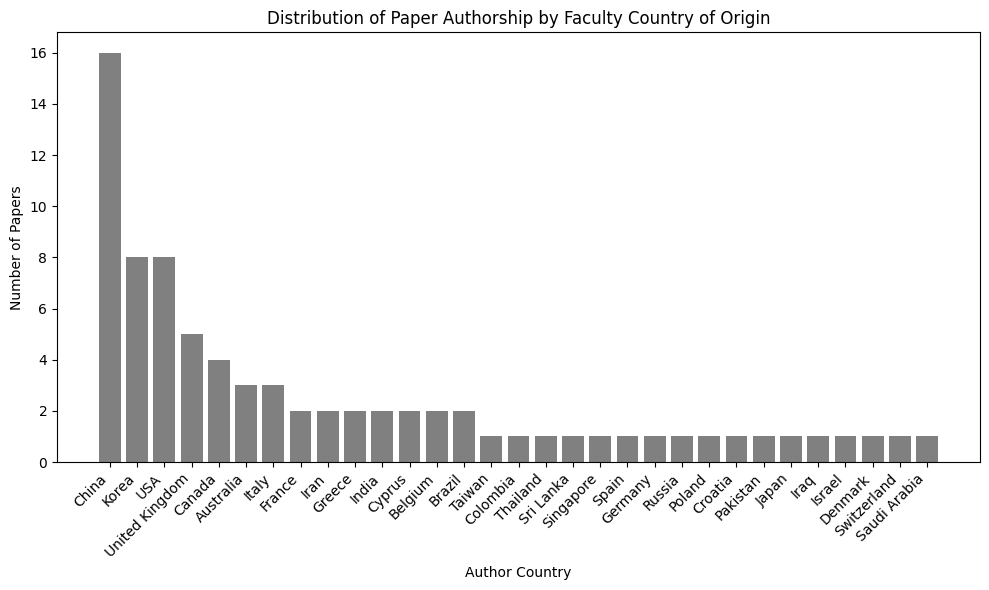

In [64]:
# Country origin count - Count country once per article
author_country_counts = author_article_country_per_article['Author country'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(author_country_counts.index, author_country_counts.values, color='gray')
plt.xlabel('Author Country')
plt.ylabel('Number of Papers')
plt.title('Distribution of Paper Authorship by Faculty Country of Origin')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Figure shows the number of articles by authors' faculty country of origin, with each country counted once per article to reflect international collaboration.

In [65]:
# prompt: print a list off all entries in Author faculty

# Assuming 'author_background_tagged_articles_df' is your DataFrame
#unique_faculty = author_background_tagged_articles_df['Author faculty'].unique().tolist()
#unique_faculty

In [66]:
# Faculty categories

# Mapping of departments to categories

department_category_mapping = {
    # Computer Science and Information Technology
    'Department of Digital Systems': 'Computer Science and Information Technology',
    'Faculty of Informatics': 'Computer Science and Information Technology',
    'Department of Computer Science': 'Computer Science and Information Technology',
    'Department of Mathematics and Computer Science': 'Computer Science and Information Technology',
    'School of Electronic and Information Engineering': 'Computer Science and Information Technology',
    'mathematics and computer science (digital vision)': 'Computer Science and Information Technology',
    'Computer Science Department': 'Computer Science and Information Technology',
    'Department of Creative Technologies': 'Computer Science and Information Technology',
    'School of Computer Science and Engineering': 'Computer Science and Information Technology',
    'Department of Computer Engineering': 'Computer Science and Information Technology',
    'Department of Information Technology': 'Computer Science and Information Technology',
    'Department of Artificial Intelligence': 'Computer Science and Information Technology',
    'Information Systems': 'Computer Science and Information Technology',
    'Artificial Intelligence and Computational Linguistics': 'Computer Science and Information Technology',
    'School of Information Management\n& Engineering': 'Computer Science and Information Technology',
    'School of Computer and Software': 'Computer Science and Information Technology',
    'Faculty of Information Technology': 'Computer Science and Information Technology',
    'Data Science & AI': 'Computer Science and Information Technology',
    'Department of Machine Learning': 'Computer Science and Information Technology',
    'Data science and information technology': 'Computer Science and Information Technology',
    'Computer Science and Technology': 'Computer Science and Information Technology',
    'Computer Science and Technology and security': 'Computer Science and Information Technology',
    'Data/Information Science, Machine Learning': 'Computer Science and Information Technology',
    'Institute of Computer Science and Technology': 'Computer Science and Information Technology',
    #'CNRS-LIG': 'Computer Science and Information Technology',
    'School of Information Technology': 'Computer Science and Information Technology',
    'Department of Statistics & Computer Science': 'Computer Science and Information Technology',
    'School of Computer Science & Engineering': 'Computer Science and Information Technology',
    'Information Technology Department, Faculty\nof Computing and Information Technology': 'Computer Science and Information Technology',
    'Department of Computer Science and Information Technology': 'Computer Science and Information Technology',
    'Beijing Advanced Innovation Center for Big Data and Brain Computing': 'Computer Science and Information Technology',
    'Department of Software Engineering': 'Computer Science and Information Technology',
    'Department of Digital Systems': 'Computer Science and Information Technology',
    'Machine Learning': 'Computer Science and Information Technology',

    # Engineering
    'School of Electrical & Electronics Engineering': 'Engineering',
    'School of Electrical Engineering': 'Engineering',
    'Department of Mechanical Engineering': 'Engineering',
    'Department of Electrical and Computer\nEngineering': 'Engineering',
    'Department of Electrical and Computer\r\nEngineering': 'Engineering',
    'Viterbi Faculty of Electrical and Computer Engineering': 'Engineering',
    'Faculty of Electrical & Robotics': 'Engineering',
    'Department of Electrical and Electronics Engineering': 'Engineering',
    'Department of Industrial Engineering': 'Engineering',
    'Intelligent Systems Center / Eng Management (THINK https://isc.mst.edu/)': 'Engineering',
    'Institute of Systems Engineering': 'Engineering',
    'School of Electrical and Information Engineering': 'Engineering',
    'School of Mechanical Engineering': 'Engineering',
    'Department of Electrical and Computer Engineering': 'Engineering',
    'http://www.eng.ox.ac.uk/': 'Engineering',
    #'Institute of Advanced Technology': 'Engineering',
    #'Tainan University of Technology': 'Engineering',

    # Mathematics and Statistics
    'Department of Mathematics and Statistics': 'Mathematics and Statistics',
    'Department of Mathematics': 'Mathematics and Statistics',
    'Mathematical Institute': 'Mathematics and Statistics',
    'Department of Applied Mathematics and Statistics': 'Mathematics and Statistics',
    'School of Mathematical Sciences': 'Mathematics and Statistics',
    'Department of Statistics': 'Mathematics and Statistics',
    'School of Mathematics': 'Mathematics and Statistics',
    'Department of Applied Statistic': 'Mathematics and Statistics',
    'Departamento de Matemáticas': 'Mathematics and Statistics',
    'Department of Statistics and Applied Probability': 'Mathematics and Statistics',
    'School of Mathematics and Statistics': 'Mathematics and Statistics',
    'School of Statistics': 'Mathematics and Statistics',
    'LMIB & School of Mathematics and Systems Science': 'Mathematics and Statistics',
    'School of Statistics and Mathematics': 'Mathematics and Statistics',
    'Data Science Research Center, Department of Statistics, Faculty of Science,': 'Mathematics and Statistics',

    # Economics, Business, and Finance
    'Faculty of Economics': 'Economics, Business, and Finance',
    'Finance': 'Economics, Business, and Finance',
    'Department of Banking and Financial Markets': 'Economics, Business, and Finance',
    'Department of Economics and Management': 'Economics, Business, and Finance',
    'Graduate School of Management and Economics': 'Economics, Business, and Finance',
    'Department of Finance': 'Economics, Business, and Finance',
    'Faculty of Economics and Business': 'Economics, Business, and Finance',
    'Faculty of Economic Sciences': 'Economics, Business, and Finance',
    'Department of Quantitative Finance, Faculty of Economic Science': 'Economics, Business, and Finance',
    'Assenagon Asset Management S.A': 'Economics, Business, and Finance',
    'Business Economics and Finance': 'Economics, Business, and Finance',
    'Financial Economics and Accounting': 'Economics, Business, and Finance',
    'n Financial Economics and Accounting': 'Economics, Business, and Finance',
    'School of Business': 'Economics, Business, and Finance',
    'Faculty of Business and Economics': 'Economics, Business, and Finance',
    'Statistics and Corporate Strategies and Information Technologies and Risk Management': 'Economics, Business, and Finance',
    'Operational Risks Internal Validation department and validation of quantitative models for financial institutions': 'Economics, Business, and Finance',
    'Southwestern University of Finance and Economics': 'Economics, Business, and Finance',
    'School of Economics': 'Economics, Business, and Finance',
    'Risk Concile': 'Economics, Business, and Finance',
    'Department of International Business Management': 'Economics, Business, and Finance',

    # Natural and Cognitive Sciences
    'Department of Brain and Cognitive Engineering': 'Natural and Cognitive Sciences',
    'USDA-Natural Resources Conservation\nService': 'Natural and Cognitive Sciences',
    'Key Laboratory of Agricultural Big Data': 'Natural and Cognitive Sciences',
    'Faculty of Science': 'Natural and Cognitive Sciences',
    'Environment & Economy Research': 'Natural and Cognitive Sciences',
    'National Research Council,': 'Natural and Cognitive Sciences',

    # Management and Industrial Studies
    #'Innov-Acts Ltd': 'Management and Industrial Studies',
    'Graduate School of Service and Trade': 'Management and Industrial Studies',
    'Institute of Industrial Management': 'Management and Industrial Studies',
    'Graduate School of Industrial Management': 'Management and Industrial Studies',
    'Department of Industrial and Management Engineering': 'Management and Industrial Studies',
    'Haide College': 'Management and Industrial Studies',
    'School of Humanities and Management': 'Management and Industrial Studies',
    'School of Labor Economics': 'Management and Industrial Studies',
    'School of Management': 'Management and Industrial Studies',
    'School of Management Science and Engineering': 'Management and Industrial Studies',
    'Changwang School of Honors,': 'Management and Industrial Studies',
    'Changwang School of Honor': 'Management and Industrial Studies',
    'Department of International Trade': 'Management and Industrial Studies'
}


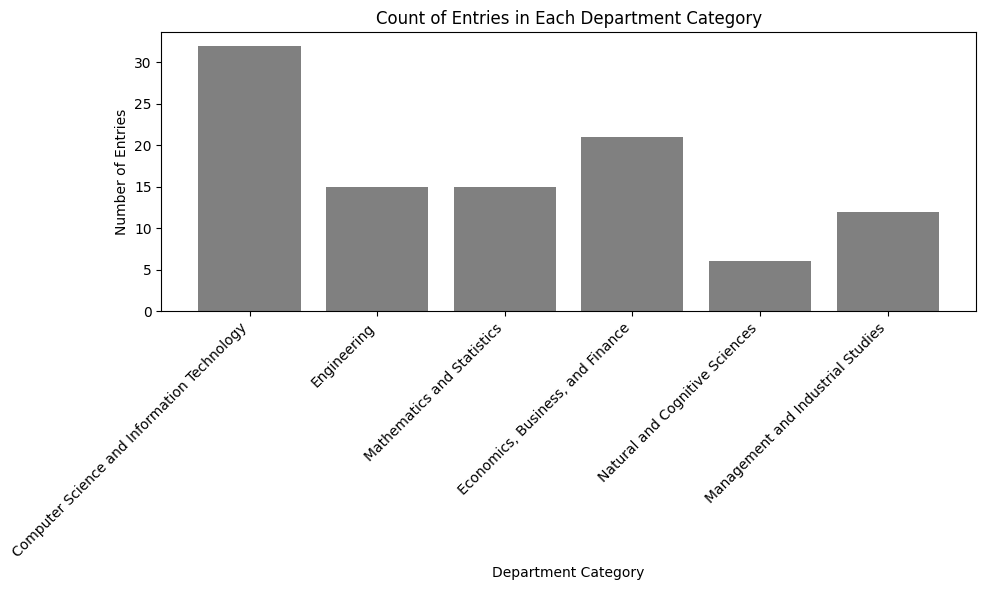

In [67]:
# prompt: make a gprahp shoing count of entriesd in each category: department_category_mapping

# Count the number of entries in each category
category_counts = {}
for department in department_category_mapping:
  category = department_category_mapping.get(department)
  if category:
    if category not in category_counts:
      category_counts[category] = 0
    category_counts[category] += 1

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='grey')
plt.xlabel('Department Category')
plt.ylabel('Number of Entries')
plt.title('Count of Entries in Each Department Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

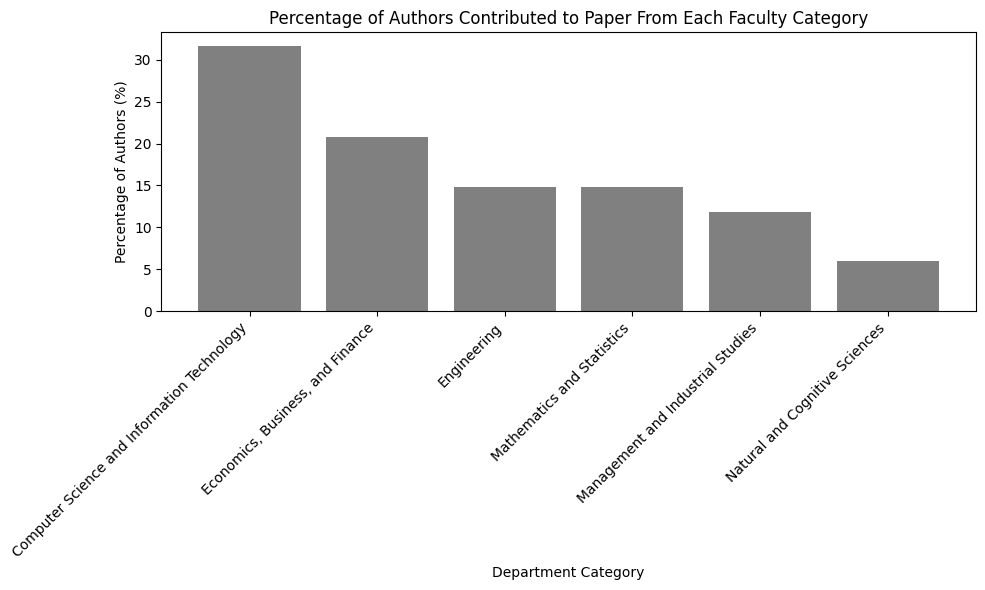

In [68]:
# prompt: make the same graph as bove for department_category_mapping, but use presentege on y-axis

# Calculate the total number of entries
total_entries = sum(category_counts.values())

# Calculate the percentage for each category
category_percentages = {category: (count / total_entries) * 100 for category, count in category_counts.items()}

sorted_category_percentages = dict(sorted(category_percentages.items(), key=lambda item: item[1], reverse=True))


# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_category_percentages.keys(), sorted_category_percentages.values(), color='grey')
plt.xlabel('Department Category')
plt.ylabel('Percentage of Authors (%)')
plt.title('Percentage of Authors Contributed to Paper From Each Faculty Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.3.6 What is predicted

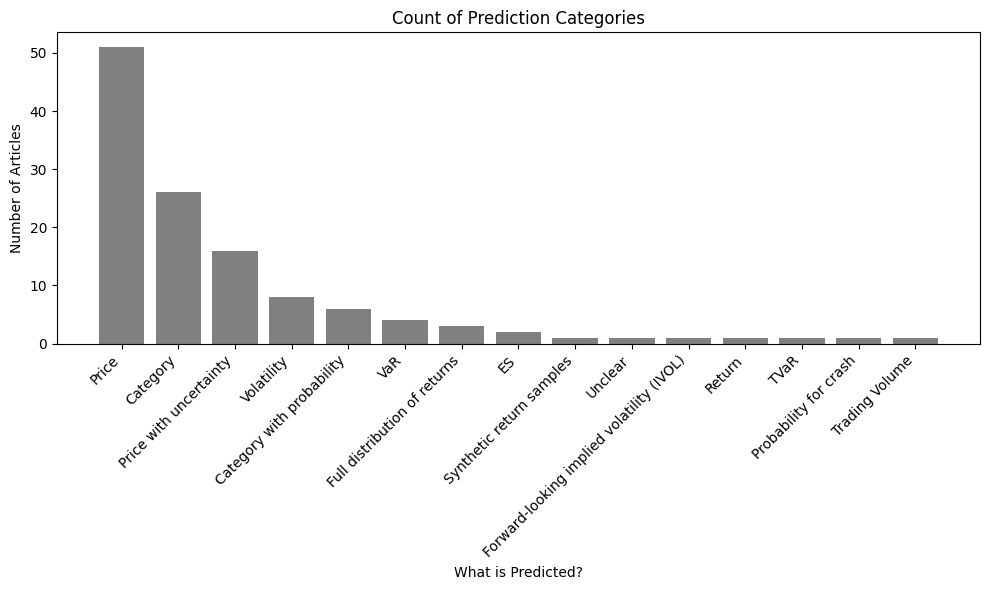

In [69]:
## prompt: # prompt: Make a grey bar chat of what is predicted? tagged_articles_all_info_df 'What is predicted?'. Some of the entries has a comma seperated value with muliple categories. I want ech uniqe category should be countes seperatlty at ech of their respective catagory. Sort high to low

# Create a new DataFrame with each unique category counted separately
prediction_counts = tagged_articles_all_info_df['What is predicted?'].str.split(',').explode().str.strip().value_counts()

# Sort the counts in descending order
prediction_counts = prediction_counts.sort_values(ascending=False)

# Create the bar chart with grey bars
plt.figure(figsize=(10, 6))
bars = plt.bar(prediction_counts.index, prediction_counts.values, color='gray')

# Add labels and title
plt.xlabel('What is Predicted?')
plt.ylabel('Number of Articles')
plt.title('Count of Prediction Categories')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Adjust layout for better visualization
plt.tight_layout()

# Display the chart
plt.show()


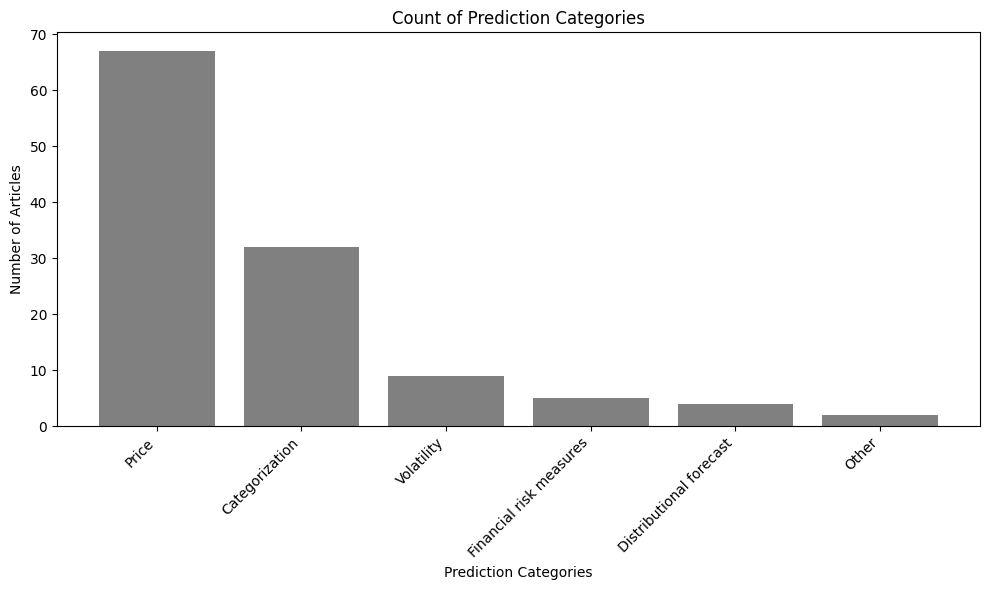

In [70]:
# Create a copy of the relevant columns to avoid modifying the original DataFrame
df_copy = tagged_articles_all_info_df[['What is predicted?']].copy()

# Define the mapping from specific prediction types to the 6 categories
mapping = {
    'Price': 'Price',
    'Price with uncertainty': 'Price',
    'Full distribution of returns': 'Distributional forecast',
    'Synthetic return samples': 'Distributional forecast',
    'Volatility': 'Volatility',
    'Forward-looking implied volatility (IVOL)': 'Volatility',
    'VaR': 'Financial risk measures',
    'TVaR': 'Financial risk measures',
    'Category': 'Categorization',
    'Category with probability': 'Categorization',
    'Trading Volume': 'Other',
    'Unclear': 'Other'
}

# Split 'What is predicted?' by comma, explode the list to individual rows, and strip whitespaces
df_copy['What is predicted?'] = df_copy['What is predicted?'].str.split(',')
df_copy = df_copy.explode('What is predicted?').reset_index(drop=True)
df_copy['What is predicted?'] = df_copy['What is predicted?'].str.strip()

# Map the prediction types to the defined categories
df_copy['Category'] = df_copy['What is predicted?'].map(mapping)

# Count the occurrences of each category
prediction_counts = df_copy['Category'].value_counts()

# Sort the counts in descending order
prediction_counts = prediction_counts.sort_values(ascending=False)

# Create the bar chart with grey bars
plt.figure(figsize=(10, 6))
bars = plt.bar(prediction_counts.index, prediction_counts.values, color='gray')

# Add labels and title
plt.xlabel('Prediction Categories')
plt.ylabel('Number of Articles')
plt.title('Count of Prediction Categories')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout for better visualization
plt.tight_layout()

# Display the chart
plt.show()

### 2.3.6 By journal and publisher


In [71]:
tagged_articles_all_info_df['Source Title'].value_counts()

,count
Source Title,
IEEE Access,11
QUANTITATIVE FINANCE,6
EXPERT SYSTEMS WITH APPLICATIONS,4
Neural Computing and Applications,3
PLOS ONE,3
...,...
IEEE Transactions on Artificial Intelligence,1
IEEE TRANSACTIONS ON PATTERN ANALYSIS AND MACHINE INTELLIGENCE,1
PLoS ONE,1


In [72]:
source_title_sum = tagged_articles_all_info_df['Source Title'].value_counts().sum()
print(source_title_sum)
journal_categories = {
    "Engineering and Technical": [
        "IEEE Access",
        "IEEE Transactions on Computational Social Systems",
        "Mobile Information Systems",
        "The Institute of Electrical and Electronics Engineers, Inc. (IEEE) Conference Proceedings.",
        "IEEE Transactions on Industrial Informatics",
        "Sensors",
        "CMC-Computers Materials & Continua",
        "Journal of Theoretical and Applied Information Technology",
        "Frontiers in Energy Research"

    ],
    "Computer Science and Artificial Intelligence": [
        "Expert Systems with Applications",
        "Applied Soft Computing",
        "IEEE Transactions on Artificial Intelligence",
        "International Journal of Data Science and Analytics",
        "IEEE Transactions on Neural Networks and Learning Systems",
        "Machine Learning with Applications",
        "Engineering Applications of Artificial Intelligence",
        "Neural Networks",
        "Expert Systems",
        "Knowledge-Based Systems",
        "IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics)",
        "Cognitive Computation",
        "Intelligent Data Analysis",
        "IEEE Transactions on Pattern Analysis and Machine Intelligence",
        "AI Communications",
        "PeerJ Computer Science",
        "Neural Computing and Applications",
        "Neurocomputing",
        "International Journal of Artificial Intelligence",
        "Knowledge-Based Systems"
    ],
    "Multidisciplinary and General Science": [
        "PLoS ONE",
        "Technological Forecasting and Social Change",
        "Trends in Sciences",
        "Sustainability",
        "Applied Sciences-Basel",
        "Stat",
        "Interdisciplinary Description of Complex Systems",
        "Resources Policy"
    ],
    "Economics, Finance, and Business": [
        "Quantitative Finance",
        "SIAM Journal on Financial Mathematics",
        "Journal of Risk Model Validation",
        "Digital Finance",
        "Computational Economics",
        "Research in International Business and Finance",
        "Financial Analysts Journal",
        "International Journal of Economics and Business Research",
        "Revista Perspectiva Empresarial",
        "Journal of Forecasting",
        "Journal of Computational Finance"
    ],
    "Physics and Mathematics": [
        "Physica A-Statistical Mechanics and its Applications",
        "Chaos",
        "Journal of Physics: Conference Series",
        "Communications in Applied Mathematics and Computational Science",
        "Mathematics",
        "Mathematics and Computers in Simulation",
        "IAENG International Journal of Applied Mathematics",
        "Journal of Statistical Computation and Simulation",
        "Technometrics"
        ]
}


category_counts = {category: 0 for category in journal_categories}

for journal in tagged_articles_all_info_df['Source Title']:
    journal_added = False
    journal = journal.lower()
    for category, journals in journal_categories.items():
        journals_l = [journal.lower() for journal in journals]
        if journal in journals_l:
            category_counts[category] += 1
            journal_added = True
            break
    if not journal_added:
      print(journal + " not added")


print(category_counts)
sum = 0
for category, count in category_counts.items():
  sum += count
print(sum)

133
neural computing & applications not added
bulletin of electrical engineering and informatics not added
malaysian journal of fundamental and applied sciences not added
annals of operations research not added
applied energy not added
global finance journal not added
ieee transactions on neural networks not added
ieee transactions on industry applications not added
ieee systems journal not added
ieee transactions on engineering management not added
psu research review not added
computational statistics & data analysis not added
computing and informatics not added
scientific reports not added
econometrics journal not added
nature communications not added
intelligent decision technologies not added
applied mathematical finance not added
ieee transactions on neural networks not added
international journal of machine learning and computing not added
international journal of advances in soft computing and its applications not added
mineral economics not added
international journal of minin

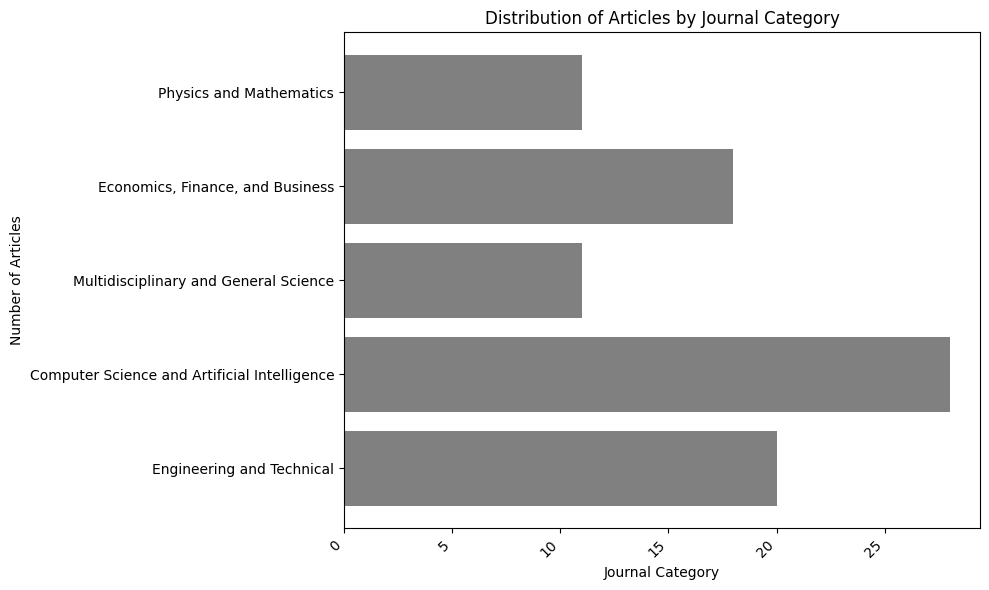

In [73]:
# Recalculate total count for each category by grouping
categories = list(category_counts.keys())
counts = list(category_counts.values())

# Create the bar chart with grey bars
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(categories, counts, color='gray')

# Customize the chart
plt.xlabel('Journal Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles by Journal Category')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels

# Show the chart
plt.show()



## 2.2 Analysis by model

In [74]:
#creating a copy of the dataframe
tagged_articles_all_info_models_df = tagged_articles_all_info_df.copy()

#creating all categories (TODO: agree on final categorization)

#a count per use of different models [x,y], where x - number of times pure use of model, y-number of times model is used in ensemble/combination

count_per_category = {"Bayesian Neural Networks (BNN)": [0,0,0,0], "Gaussian Processes (GP)": [0,0,0,0], "Hidden Markov Models (HMM)": [0,0,0,0],
                      "Variational Autoencoders (VAE)": [0,0,0,0], "Probabalistic RNN Extensions": [0,0,0,0],
                      "Probabalistic Generative Adversial Networks":[0,0,0,0], "Probabalistic Neural Networks":[0,0,0,0],
                       "Other Bayesian Methods":[0,0,0,0], "Other Probabalistic Methods": [0,0,0,0]}

article_model_names_per_category = {"Bayesian Neural Networks (BNN)": [], "Gaussian Processes (GP)": [], "Hidden Markov Models (HMM)": [], "Variational Autoencoders (VAE)": [], "Probabalistic RNN Extensions": [],
                      "Probabalistic Generative Adversial Networks":[], "Probabalistic Neural Networks":[], "Other Bayesian Methods":[], "Other Probabalistic Methods": []}

article_title_per_category = {"Bayesian Neural Networks (BNN)": [], "Gaussian Processes (GP)": [], "Hidden Markov Models (HMM)": [], "Variational Autoencoders (VAE)": [], "Probabalistic RNN Extensions": [],
                      "Probabalistic Generative Adversial Networks":[], "Probabalistic Neural Networks":[], "Other Bayesian Methods":[], "Other Probabalistic Methods": []}

In [75]:
#Creating a dictionary that creates all the words associated with each category (TODO: Make correct categories and label each model in a category)
#Should we add a "Other Probabalistic methods?" (Maybe instead of the "Other Bayesian methods")
keywords_per_category = {"Bayesian Neural Networks (BNN)": ["BNN", "Gen-BNN", "B-TABL"],

                         "Gaussian Processes (GP)": ["GPR", "GP", "G4P", "GPMCH"],

                         "Variational Autoencoders (VAE)": ["VAE"],

                         "Hidden Markov Models (HMM)": ["HMM", "MCHMM"],

                         "Probabalistic RNN Extensions" : ["DeepAR ", "DeepARA", "P-GRU", "QRBiLSTM", "ESVM", "Bayesian LSTM", "Bayes ES-RNN"],

                         "Probabalistic Generative Adversial Networks" : ["CGAN", "PredACGAN"],

                         "Probabalistic Neural Networks": ["PNN", "P FF-ANN"],

                         "Other Bayesian Methods":["Facebook Prophet", "B-SVR", "BGLM", "Naïve Bayes (NB)", "Bayesian Network (BN)", "Bayesian Structural Time Series (BSTS)",
                                                   "Multivariate Bayesian Structural Time Series (MBSTS)"],

                         "Other Probabalistic Methods":["RSMAN", "PLPR", "Recurrent Dictionary Learing (RDL)", "TV-Entropy", "Gaussian Mixture Model (GMM)",
                                                        "IMoLSO", "Fitting error analysis", "Probabilistic Fuzzy Logic [PFL]", "Leave-One-Out Cross-Conformal Predictive System (LOO-CCPS)",
                                                        "Probabilistic Support Vector Machine (PSVM)", "DCNN", "Fuzzy neural systems (FNS)", "Deep Convolutional Neural Network (DCNN)"]
                         }

#needs to be tagged:


In [76]:
model_names = tagged_articles_all_info_models_df[["Title_notion","Prob AI model name", "Composed with ML models", "Composed with traditional models"]]
all_models = []

hardcodes_models = {"Bayesian exponential smoothed RNNs (Bayes ES-RNN) (BNN)":"Probabalistic RNN Extensions"}
hardcodes_titles = {"Selecting data adaptive learner from multiple deep learners using Bayesian networks":"Other Bayesian Methods",
                    "Forecasting stock market index daily direction: A Bayesian Network approach": "Other Bayesian Methods"}

# Iterate over rows and apply logic
for index, model in model_names.iterrows():
  model_added_to = None
  print("----------------")
  print("Model name", model["Prob AI model name"])
  all_models.append(model["Prob AI model name"])

  #Hardcoded classify
  if model["Prob AI model name"] in hardcodes_models.keys():
    category = hardcodes_models[model["Prob AI model name"]]
    count_per_category[category][0] += 1
    article_model_names_per_category[category].append(model["Prob AI model name"])
    article_title_per_category[category].append(model["Title_notion"])
    print("Model ", model["Prob AI model name"], " was added to the category ", category, " based on the hardcoded keywords" )
    model_added_to = category

  if model["Title_notion"] in hardcodes_titles.keys():
    category = hardcodes_titles[model["Title_notion"]]
    count_per_category[category][0] += 1
    article_model_names_per_category[category].append(model["Prob AI model name"])
    article_title_per_category[category].append(model["Title_notion"])
    print("Model ", model["Prob AI model name"], " was added to the category ", category, " based on the hardcoded keywords" )
    model_added_to = category

  #classifying the model
  for category, keywords in keywords_per_category.items():
    if model_added_to:
      break
    # Do nothing if all cells are NaN
    if pd.isnull(model["Prob AI model name"]):
      print("All cells are NaN")
      break
    for keyword in keywords:
      if keyword in model["Prob AI model name"]:

        if pd.notnull(model['Prob AI model name']) and model[['Composed with ML models', 'Composed with traditional models']].isnull().all():
          count_per_category[category][0] += 1
          article_model_names_per_category[category].append(model["Prob AI model name"])
          article_title_per_category[category].append(model["Title_notion"])
          print("Model ", model["Prob AI model name"], " was added to the category ", category, "based on the keyword ", keyword )
          model_added_to = category
          break

        elif pd.notnull(model['Prob AI model name']) and pd.notnull(model['Composed with ML models']) and pd.isnull(model["Composed with traditional models"]):
          count_per_category[category][1] += 1
          article_model_names_per_category[category].append(model["Prob AI model name"])
          article_title_per_category[category].append(model["Title_notion"])
          print("Model ", model["Prob AI model name"], " was added to the category ", category, "based on the keyword ", keyword, " combined with an ML model" )
          model_added_to = category
          break

        elif pd.notnull(model['Prob AI model name']) and pd.notnull(model['Composed with traditional models']) and pd.isnull(model["Composed with ML models"]):
          count_per_category[category][2] += 1
          article_model_names_per_category[category].append(model["Prob AI model name"])
          article_title_per_category[category].append(model["Title_notion"])
          print("Model ", model["Prob AI model name"], " was added to the category ", category, "based on the keyword ", keyword, " combined with a traditional model" )
          model_added_to = category
          break

        else:
          count_per_category[category][3] += 1
          article_model_names_per_category[category].append(model["Prob AI model name"])
          article_title_per_category[category].append(model["Title_notion"])
          print("Model ", model["Prob AI model name"], " was added to the category ", category, "based on the keyword ", keyword, " combined with an ML model and a traditional model" )
          model_added_to = category
          break


  if model_added_to:
    tagged_articles_all_info_models_df.loc[index, "Model category"] = model_added_to
    tagged_articles_all_info_df.loc[index, "Model category"] = model_added_to
  else:
    print("🚩 MODEL NOT ADDED ")



----------------
Model name Bayesian Structural Time Series (BSTS)
Model  Bayesian Structural Time Series (BSTS)  was added to the category  Other Bayesian Methods based on the keyword  Bayesian Structural Time Series (BSTS)  combined with an ML model
----------------
Model name Bayesian Structural Time Series (BSTS)
Model  Bayesian Structural Time Series (BSTS)  was added to the category  Other Bayesian Methods based on the keyword  Bayesian Structural Time Series (BSTS)
----------------
Model name Bayesian Structural Time Series (BSTS)
Model  Bayesian Structural Time Series (BSTS)  was added to the category  Other Bayesian Methods based on the keyword  Bayesian Structural Time Series (BSTS)
----------------
Model name Deep Convolutional Neural Network (DCNN)
Model  Deep Convolutional Neural Network (DCNN)  was added to the category  Other Probabalistic Methods based on the keyword  DCNN  combined with a traditional model
----------------
Model name Variational Auto-encoder (VAE)
Mode

In [77]:
print(all_models)

['Bayesian Structural Time Series (BSTS)', 'Bayesian Structural Time Series (BSTS)', 'Bayesian Structural Time Series (BSTS)', 'Deep Convolutional Neural Network (DCNN)', 'Variational Auto-encoder (VAE)', 'Generative Bayesian Neural Network (Gen-BNN)', 'Hidden Markov Model (HMM)', 'DeepAR (based on autoregressive RNN)', 'Probabilistic Linguistic Preference Relationships (PLPR)', 'Facebook Prophet (Bayesian nonlinear univariate generative model related to time series prediction)', 'Conditional Generative Adversarial Network (CGAN)', 'TV-Entropy', 'DeepAR (based on autoregressive RNN)', 'Bayesian Support Vector Regression (B-SVR)', 'BNN-SVR, Bayesian Neural Network (BNN)', 'Bayesian temporal attention augmented bilinear network (B-TABL)', 'Gaussian Process Regression (GPR)', 'DeepAR with attention (DeepARA)', 'Recurrent Dictionary Learing (RDL)', 'Bayesian LSTM with Monte Carlo Drouput', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regressio

In [78]:
print(count_per_category)

{'Bayesian Neural Networks (BNN)': [5, 2, 0, 0], 'Gaussian Processes (GP)': [10, 1, 1, 1], 'Hidden Markov Models (HMM)': [4, 2, 0, 0], 'Variational Autoencoders (VAE)': [1, 4, 1, 0], 'Probabalistic RNN Extensions': [8, 0, 0, 0], 'Probabalistic Generative Adversial Networks': [3, 1, 0, 0], 'Probabalistic Neural Networks': [3, 1, 0, 0], 'Other Bayesian Methods': [9, 1, 0, 0], 'Other Probabalistic Methods': [5, 4, 2, 1]}


In [79]:
print(article_model_names_per_category)

{'Bayesian Neural Networks (BNN)': ['Generative Bayesian Neural Network (Gen-BNN)', 'BNN-SVR, Bayesian Neural Network (BNN)', 'Bayesian temporal attention augmented bilinear network (B-TABL)', 'Bayesian Neural Network (BNN), WaveNet', 'Bayesian neural networks (BNNs)', 'deep Bayesian neural networks (BNNs)', 'Langevin-gradient Bayesian neural networks (BNN) with parallel tempering Markov Chain Monte Carlo (MCMC)'], 'Gaussian Processes (GP)': ['Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)', 'nonparametric Bayesian mixture of Gaussian process regression models (GPMCH)', 'Graph-Aware Gaussian Process (G4P)', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)', 'Gaussian Process(GP), Stochastic Multilayer Perceptron (S-MLP)', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)', 'Gaussian Process Regression (GPR)']

In [80]:
for key in article_title_per_category:
  print(key, "    :    ", article_title_per_category[key])
  print()

Bayesian Neural Networks (BNN)     :     ['Generative Bayesian neural network model for risk-neutral pricing of American index options', 'Predictions of bitcoin prices through machine learning based frameworks', 'Bayesian bilinear neural network for predicting the mid-price dynamics in limit-order book markets', 'Forecasting VIX using Bayesian deep learning', 'An Empirical Study on Modeling and Prediction of Bitcoin Prices With Bayesian Neural Networks Based on Blockchain Information', 'Long-term financial predictions based on Feynman-Dirac path integrals, deep Bayesian networks and temporal generative adversarial networks', 'Bayesian neural networks for stock price forecasting before and during COVID-19 pandemic']

Gaussian Processes (GP)     :     ['Time-series forecasting using manifold learning, radial basis function interpolation, and geometric harmonics', 'Parametric models and non-parametric machine learning models for predicting option prices: Empirical comparison study over KO

<ipython-input-81-d42ed30fc41e>:23: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



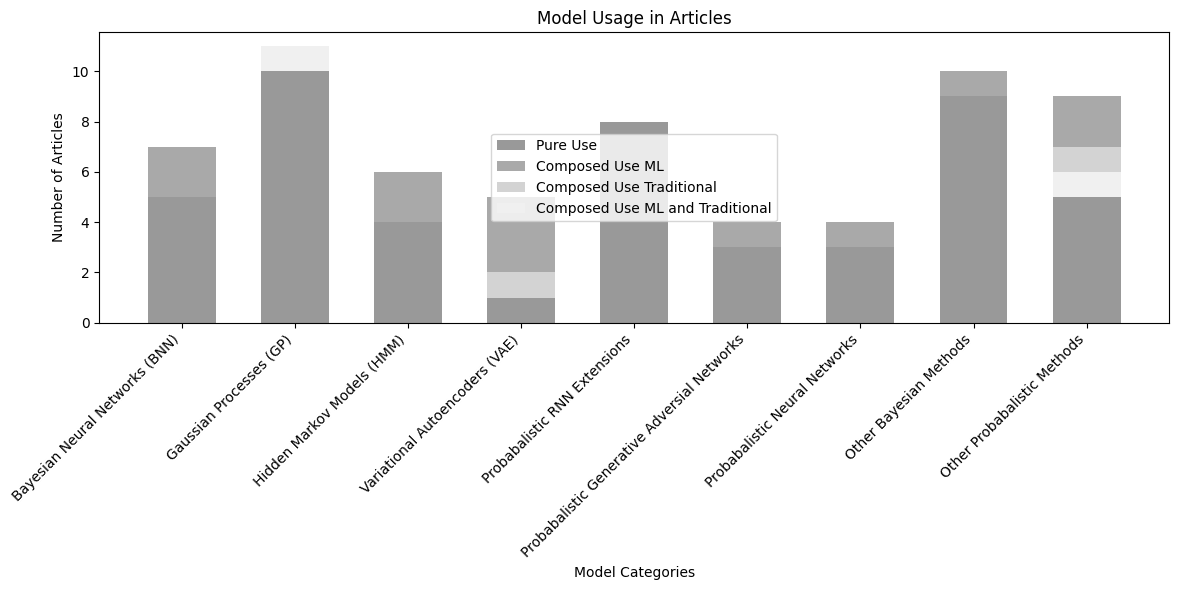

In [81]:
# prompt: Generate a stacked barchart, where on the X axis is the categories in the count_per_category dictionary, and the y-axis is the count associated with that category. This count is diveded in two in list, where the first value correspond to the first part of the stacked bar, and the second value the other part

import matplotlib.pyplot as plt

categories = list(count_per_category.keys())
pure_counts = [count[0] for count in count_per_category.values()]
ml_comb_counts = [count[1] for count in count_per_category.values()]
trad_comb_counts = [count[2] for count in count_per_category.values()]
ml_and_trad_counts = [count[3] for count in count_per_category.values()]

colors = ['#999999', '#A9A9A9', '#D3D3D3', '#F0F0F0']
width = 0.6  # the width of the bars
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(categories, pure_counts, width, label='Pure Use', color=colors[0])
ax.bar(categories, ml_comb_counts, width, bottom=pure_counts, label='Composed Use ML', color=colors[1])
ax.bar(categories, trad_comb_counts, width, bottom=pure_counts, label='Composed Use Traditional', color=colors[2])
ax.bar(categories, ml_and_trad_counts, width, bottom=pure_counts, label='Composed Use ML and Traditional', color=colors[3])

ax.set_xlabel("Model Categories")
ax.set_ylabel("Number of Articles")
ax.set_title("Model Usage in Articles")
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


## 2.3 Analysis by target variable

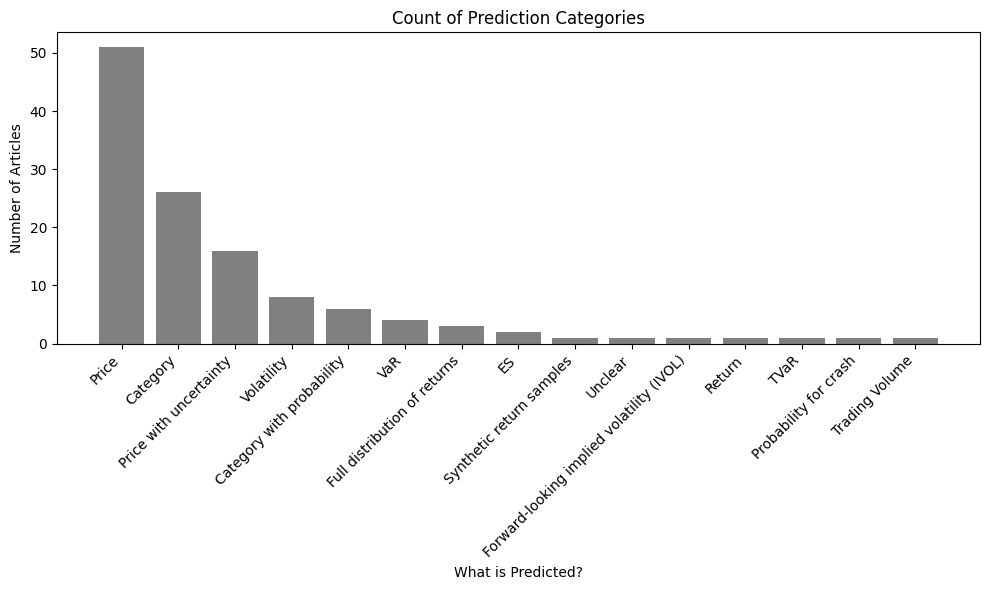

In [82]:
# 1. Price 2. Distributional forecast  3. Volatility  4. Financial risk measures (VaR, TVaR)  5. Categorization (e.g. up/down)

# Create a new DataFrame with each unique category counted separately
prediction_counts = tagged_articles_all_info_df['What is predicted?'].str.split(',').explode().str.strip().value_counts()

# Sort the counts in descending order
prediction_counts = prediction_counts.sort_values(ascending=False)

# Create the bar chart with grey bars
plt.figure(figsize=(10, 6))
bars = plt.bar(prediction_counts.index, prediction_counts.values, color='gray')

# Add labels and title
plt.xlabel('What is Predicted?')
plt.ylabel('Number of Articles')
plt.title('Count of Prediction Categories')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Adjust layout for better visualization
plt.tight_layout()

# Display the chart
plt.show()



## 2.4 Analysis by asset

#### 2.4.1 Chart by all asset categories

['Stocks', 'Commodities, Cryptocurrency, Forex, Stock indices', 'Stocks', 'Volatility index', 'Portfolio, Stocks', 'Options', 'Stocks', 'Portfolio', 'Stock indices', 'Commodities', 'Stock indices', 'Stock indices', 'Cryptocurrency', 'Bonds, Commodities, Credit Default Swap (CDS) Spreads, Stock indices', 'Cryptocurrency', 'Stocks', 'Forex', 'Stocks', 'Stocks', 'Cryptocurrency', 'Options', 'Capped volatility swaps', 'Stock indices', 'Stock indices', 'Cryptocurrency', 'Portfolio', 'Stock indices', 'Stock indices, Stocks', 'Stocks', 'Stock indices, Stocks', 'Portfolio, Stocks', 'Portfolio, Stocks', 'Commodities', 'Commodities', 'Commodities', 'Portfolio', 'Stocks', 'Forex, Options, Stock indices, Stocks', 'Forex, Stock indices', 'Portfolio', 'Derivative index', 'Volatility index', 'Derivatives', 'Commodities', 'Stock indices', 'Stock indices', 'Forex, Stock indices', 'Stocks', 'Cryptocurrency', 'Portfolio, Stocks', 'Stock indices', 'Stocks', 'Stocks', 'Stock indices', 'Portfolio', 'Portfol

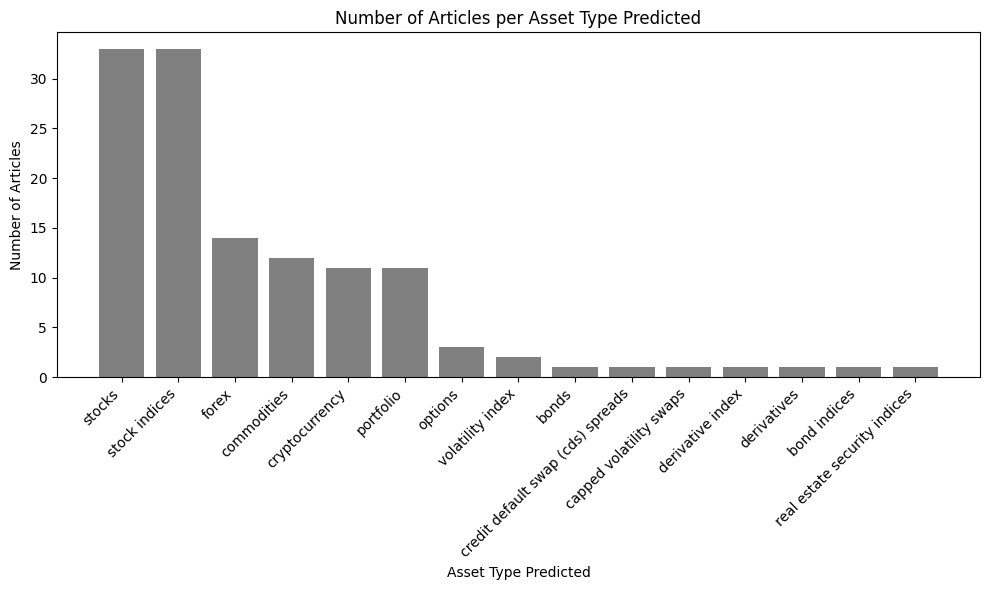

In [83]:
# prompt: make a bar chart of number of articles asset type predicted in graey color. Some entreis has a list of multiple assets they are prediction. split this up based on comma and if the list countais another existing entyr then count it at all the driffente types of asset, not combinend a e group. make sure not to have duplicate entries o nthe y azxiz

asset_types = tagged_articles_all_info_df['Type of asset'].dropna().tolist()
print(asset_types)
print(asset_types.count("Cryptocurrency"))

# Create a dictionary to store the counts of each asset type
asset_type_counts = { }

# Loop through the asset types and split them by comma
for asset_type_list in asset_types:
    # Split the asset types by comma and clean them up
    asset_types_split = [asset_type.strip().lower() for asset_type in asset_type_list.split(',')]

    # Count each asset type
    for asset_type in asset_types_split:
        if asset_type in asset_type_counts:
            asset_type_counts[asset_type] += 1
        else:
            asset_type_counts[asset_type] = 1

# Sort the asset types by their count in descending order
sorted_asset_types = sorted(asset_type_counts.items(), key=lambda x: x[1], reverse=True)
sorted_asset_labels, sorted_asset_counts = zip(*sorted_asset_types)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_asset_labels, sorted_asset_counts, color='gray')

# Add labels and title
plt.xlabel('Asset Type Predicted')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Asset Type Predicted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the chart
plt.tight_layout()
plt.show()


#### 2.4.2 Chart by grouped categories of assets

In [84]:
# asset_type_counts
print(asset_type_counts)
number = 0
for key in asset_type_counts:
  number += asset_type_counts[key]
print(number)


{'stocks': 33, 'commodities': 12, 'cryptocurrency': 11, 'forex': 14, 'stock indices': 33, 'volatility index': 2, 'portfolio': 11, 'options': 3, 'bonds': 1, 'credit default swap (cds) spreads': 1, 'capped volatility swaps': 1, 'derivative index': 1, 'derivatives': 1, 'bond indices': 1, 'real estate security indices': 1}
126


{'Stock indices': 33, 'Stocks': 33, 'Portfolios': 11, 'Crypto': 11, 'Forex': 14, 'Derivatives': 9, 'Commodities': 12, 'Bonds': 1}
124


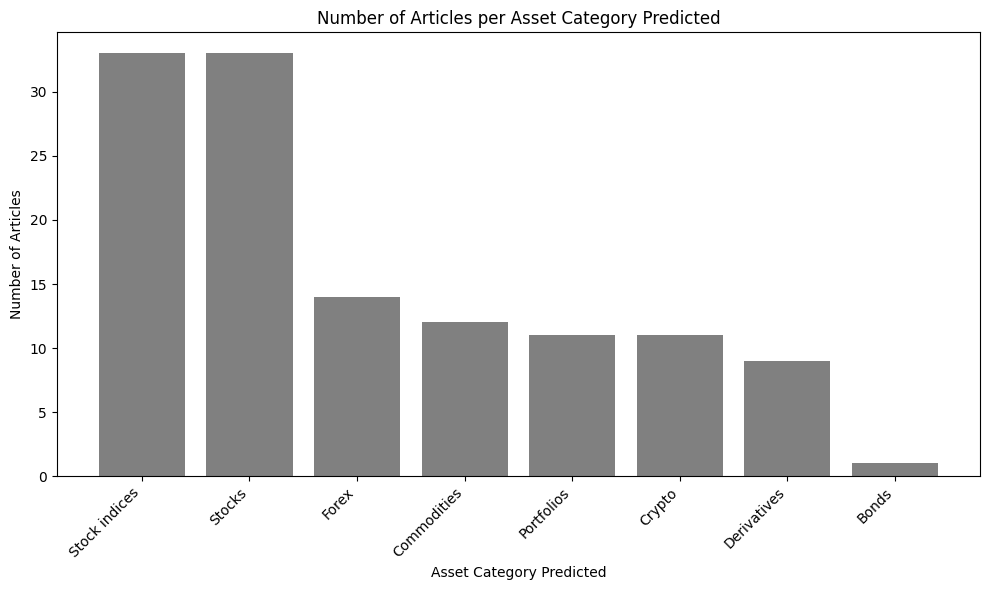

In [85]:
# prompt: make the same graph as above but gorup based ont htse catergories:
# 1. Stock indices
# 2. Stocks
# 3. Portfolios
# 4. Crypto
# 5. Forex
# 6. Derivatives
# 7. Other

asset_categories = {
    'Stock indices': ['stock indices'],
    'Stocks': ['stocks'],
    'Portfolios': ['portfolio'],
    'Crypto': ['cryptocurrency'],
    'Forex': ['forex'],
    'Derivatives': ['derivatives', 'derivative index','capped volatility swaps', 'credit default swap (cds) spreads', 'options', "volatility index" ],
    'Commodities': ['commodities'],
    'Bonds': ['bonds']
}

asset_type_counts_2 = {category: 0 for category in asset_categories}

asset_types_2 = tagged_articles_all_info_df['Type of asset'].dropna().tolist()

for asset_type_list in asset_types_2:
  asset_types_split = [asset_type.strip().lower() for asset_type in asset_type_list.split(',')]
  found_category = False

  for asset_type in asset_types_split:
    for category, keywords in asset_categories.items():
      if asset_type in keywords:
        asset_type_counts_2[category] += 1
        found_category = True
        break
    # if found_category:
    #   break
  if not found_category:
    print("  🚩 Did not find a categoruy for ", asset_type)
    asset_type_counts_2['Other'] += 1

print(asset_type_counts_2)
number_2 = 0
for key in asset_type_counts_2:
  number_2 += asset_type_counts_2[key]
print(number_2)

sorted_asset_types = sorted(asset_type_counts_2.items(), key=lambda x: x[1], reverse=True)
sorted_asset_labels, sorted_asset_counts = zip(*sorted_asset_types)


plt.figure(figsize=(10, 6))
plt.bar(sorted_asset_labels, sorted_asset_counts, color='gray')

plt.xlabel('Asset Category Predicted')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Asset Category Predicted')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 2.5 Analysis by type of uncertainty

#### 2.5.1 Count of UQ use

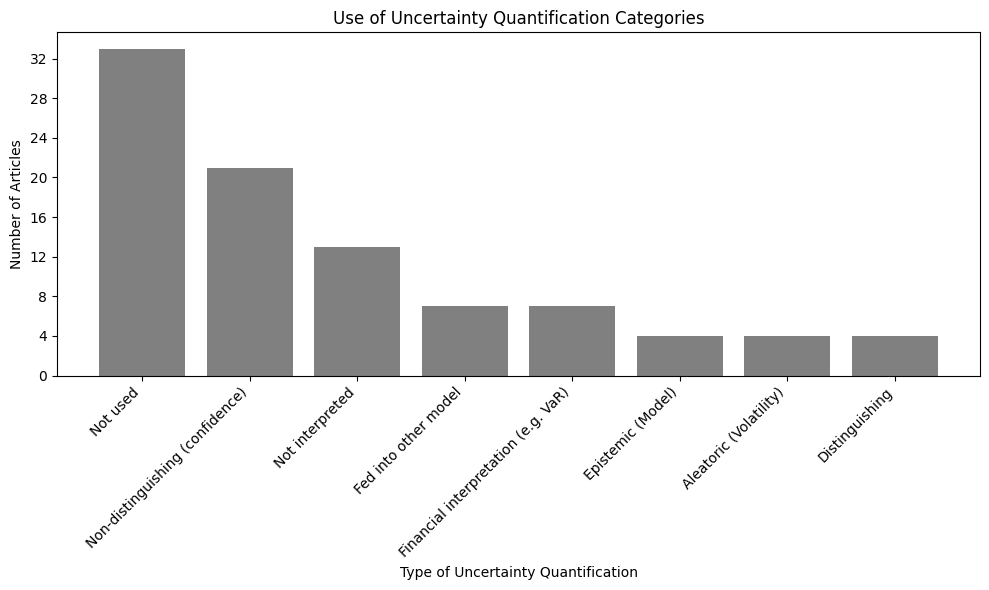

In [86]:
# prompt: I want to make a grey bar chart of the colum "Use of UQ" in tagged_articles_all_info_df. Use whole numbers on y axis. Some entreis has a list of multiple assets they are prediction. split this up based on comma and if the list countais another existing entyr then count it at all the driffente types of asset, not combinend a e group.

import matplotlib.pyplot as plt

# Assuming 'tagged_articles_all_info_df' is your DataFrame

# Create a new DataFrame with each unique category counted separately
uq_counts = tagged_articles_all_info_df['Use of UQ'].str.split(',').explode().str.strip().value_counts()

# Sort the counts in descending order
uq_counts = uq_counts.sort_values(ascending=False)

# Create the bar chart with grey bars
plt.figure(figsize=(10, 6))
bars = plt.bar(uq_counts.index, uq_counts.values, color='gray')

# Add labels and title
plt.xlabel('Type of Uncertainty Quantification')
plt.ylabel('Number of Articles')
plt.title('Use of Uncertainty Quantification Categories')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Force y axis to start at 0 and use whole numbers
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylim(bottom=0)

# Adjust layout for better visualization
plt.tight_layout()

# Display the chart
plt.show()


#### 2.5.2 Count of UQ use and assement

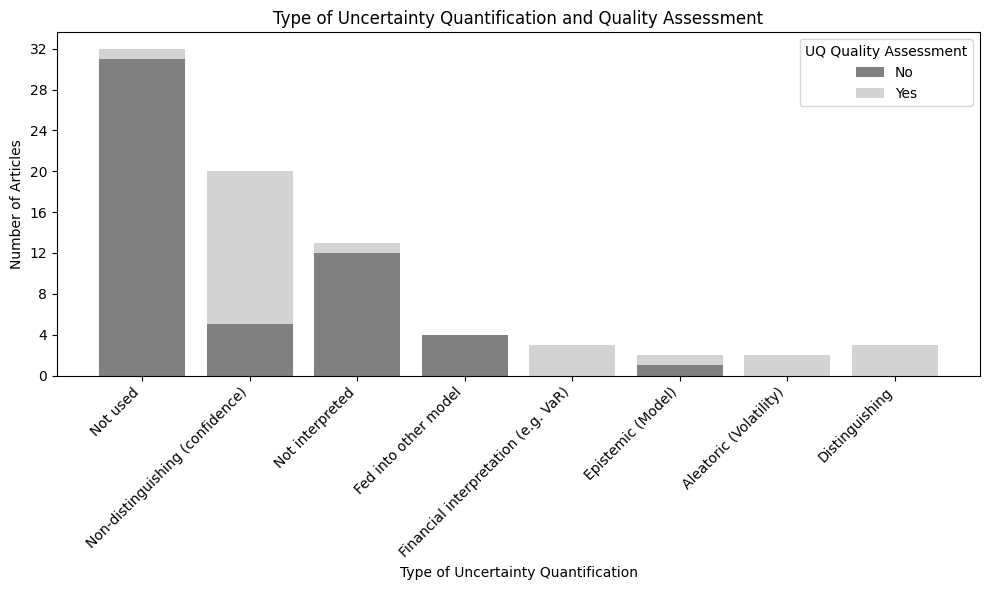

In [87]:
# prompt: # prompt: I want to make a stacked bar chart in graye scale colors. It should be of "Use of UQ" (should be on x axiss) grouped by "UQ quality assessment". sort bars high to low. In "use of UQ" some have mulitple categories sepperated by comma. count each entrey seperatly

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'tagged_articles_all_info_df' is your DataFrame

# Create a cross-tabulation of 'Use of UQ' and 'UQ quality assessment'
uq_quality_crosstab = pd.crosstab(tagged_articles_all_info_df['Use of UQ'], tagged_articles_all_info_df['UQ quality assessment'])

# Split 'Use of UQ' by comma and count each entry separately
uq_counts = tagged_articles_all_info_df['Use of UQ'].str.split(',').explode().str.strip().value_counts()

# Sort the 'Use of UQ' categories by count in descending order
uq_counts_sorted = uq_counts.sort_values(ascending=False)

# Create a list of gray scale colors
gray_colors = ['grey', '#d3d3d3', '#a9a9a9', '#808080', '#696969', '#555555']

# Create the stacked bar chart
plt.figure(figsize=(10, 6))
bottom = [0] * len(uq_counts_sorted)  # Initialize the bottom of the stacked bars

# Loop through the columns of the crosstab (UQ quality assessment)
for uq_quality in uq_quality_crosstab.columns:
  uq_quality_counts = uq_quality_crosstab[uq_quality].reindex(uq_counts_sorted.index).fillna(0)

  plt.bar(
      uq_counts_sorted.index,
      uq_quality_counts,
      bottom=bottom,
      color=gray_colors[uq_quality_crosstab.columns.get_loc(uq_quality) % len(gray_colors)],
      label=uq_quality
  )

  bottom = [b + c for b, c in zip(bottom, uq_quality_counts)]  # Update the bottom for the next bar


# Add labels and title
plt.xlabel('Type of Uncertainty Quantification')
plt.ylabel('Number of Articles')
plt.title('Type of Uncertainty Quantification and Quality Assessment')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Force y axis to start at 0 and use whole numbers
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylim(bottom=0)

# Add legend
plt.legend(title='UQ Quality Assessment')

# Adjust layout for better visualization
plt.tight_layout()

# Display the chart
plt.show()


### 2.5.3 Uncertainty Assessment Measure


['Christoffersen’s Test', 'Conditional Coverage Test', 'Independence Test', 'Kupiec’s test', "Lopez' loss function", 'Unconditional Coverage Test']
🚩 Measure  Conditional Coverage Test  NOT ADDED 
🚩 Measure  Independence Test  NOT ADDED 
🚩 Measure  Lopez' loss function  NOT ADDED 
🚩 Measure  Unconditional Coverage Test  NOT ADDED 
['Christoffersen’s Test', 'Conditional Coverage Test', 'Dynamic Quantile (DQ)', 'Firm Loss', 'Quadratic Loss (QL)', 'Smooth Loss', 'Unconditional Coverage Test']
🚩 Measure  Conditional Coverage Test  NOT ADDED 
🚩 Measure  Firm Loss  NOT ADDED 
🚩 Measure  Quadratic Loss (QL)  NOT ADDED 
🚩 Measure  Smooth Loss  NOT ADDED 
🚩 Measure  Unconditional Coverage Test  NOT ADDED 
['Correlation between uncertainty and prediction error', 'Portfolio construction and evaluation']
['Bayesian Information Criteria (BIC)', 'Coverage probabillty', 'Kupiec’s test', 'negative log-likelihood (NLL)']
🚩 Measure  Bayesian Information Criteria (BIC)  NOT ADDED 
['Continuous Ranked Pro

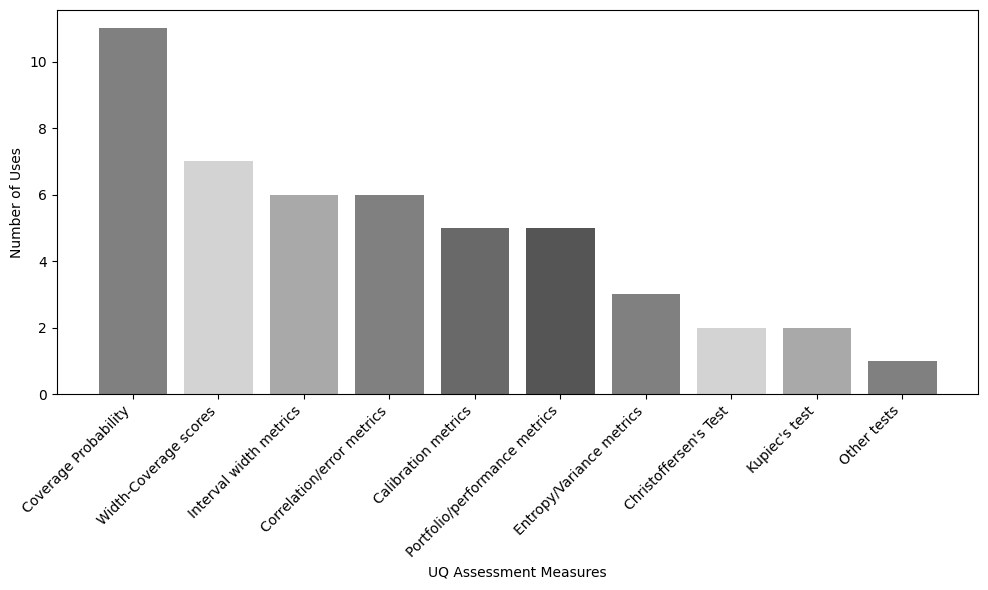

In [88]:
# Filter the DataFrame where 'Use of UQ' is 'Yes'
uq_assessed_df = tagged_articles_all_info_df[tagged_articles_all_info_df['UQ quality assessment'] == 'Yes'].dropna(subset=['Assement cirterias of uncertainty'])

# could possible merge coverage/width based scores as one category called "coverage/with scores"

measure_categories = {"Christoffersen's Test": ["Christoffersen’s Test"],
                      "Kupiec's test": ["Kupiec’s test"],
                      "Coverage Probability": ["Coverage probabillty", "PICP (Prediction interval coverage probability)", "MC (Mean coverage)"],
                      "Width-Coverage scores": ["Mean width divided by coverage probability", "Continuous Ranked Probability Score (CRPS)", "e continuous ranked probability score (CRPS)", "average interval score (AIS)",
                                                "Winkler Score", "coverage widthbased criterion (CWC)"],
                      "Interval width metrics": ["Forecasting Interval Normalized Average Width (FINAW)", "Prediction Interval Normalized Average Width (PINAW)", "Semi-interval metric", "MWP (Mean width percentage)"],
                      "Calibration metrics": ["Dynamic Quantile (DQ)", 'Quantile loss (QL)',  "Expected Calibration Distance (ECD)", "Expected Calibration Error (ECE)",
                                                    "Root Mean Squared Calibration Error (RMSCE)", "RMSCE"],
                      "Entropy/Variance metrics": ["Entropy of probability distribution", "kriging variance", 'simulation variance/instrinsic noise', "MSEV"],
                      "Portfolio/performance metrics": ["SVaR", 'Sharpe ratio', "Portfolio construction and evaluation"],
                      "Correlation/error metrics": ["Correlation between uncertainty and prediction error", "Success rate", "negative log-likelihood (NLL)", "Area Under the ROC Curve (AUROC)", 'RMSE (against squared returns)'],
                      "Other tests" : ["SES", "the largest eigenvalue of the correlation matrix"],
                      }

measure_categories_count = {category: 0 for category in measure_categories}

for row in uq_assessed_df.iterrows():
  measures = row[1]['Assement cirterias of uncertainty'].strip().split(",")
  measures = [measure.strip() for measure in measures]
  print(measures)
  for measure in measures:
    measure_added = False
    for category, keywords in measure_categories.items():
      if measure in keywords:
        measure_categories_count[category]+=1
        measure_added = True
        break
    if not measure_added:
         print("🚩 Measure ", measure, " NOT ADDED ")



print(measure_categories_count )
# Create a list of gray scale colors
gray_colors = ['grey', '#d3d3d3', '#a9a9a9', '#808080', '#696969', '#555555']
#sort the bars descending
measure_categories_count = dict(sorted(measure_categories_count.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(measure_categories_count.keys(), measure_categories_count.values(), color=gray_colors)



# add labels and title
plt.xlabel('UQ Assessment Measures')
plt.ylabel('Number of Uses')
# rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## 2.6 Bibtex

In [89]:
tagged_articles_all_info_df.columns

Index(['Assessed by', 'Status', 'ID', 'Double checked by', 'Title_notion',
       'Link_notion', 'File', 'Exclude', 'Model input', 'Horizon',
       ...
       'FX', 'TC', 'Cited by', 'WC', 'BN', 'BP', 'IEEE Terms',
       'Article Citation Count', 'PI', 'Publication Year (Year only)'],
      dtype='object', length=170)

In [90]:
tagged_articles_all_info_df.iloc[0]

,https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9448324
Assessed by,Tord/Sivert
Status,Assessed
ID,https://ieeexplore.ieee.org/stamp/stamp.jsp?ar...
Double checked by,NaN
Title_notion,A Hybrid Approach of Bayesian Structural Time ...
...,...
BP,NaN
IEEE Terms,Predictive models;Mathematical model;Data mode...
Article Citation Count,16.0
PI,NaN


In [91]:
import pandas as pd

def print_bibtex_entries(df):
    for category in df["Model category"].unique():
      print(f"""
%---------------------------------------------------------------%
% --------------- {category} articles from sample
%---------------------------------------------------------------%
""")
      for index, row in df[df["Model category"] == category].iterrows():
          title = row['Title_db']
          authors = row['Authors']
          journal = row['Source Title']
          year = str(row['Publication Year']).split("-")[0]
          volume = row['Volume']
          number = row["Issue"]
          doi = str(row['DOI']).replace("https://doi.org/", "")

          identifier = authors.split(",")[0].split(" ")[0].split("-")[0].lower() + year + title.split(" ")[0].split("-")[0].split(":")[0].split(r"\W")[0].lower()


          # Basic BibTeX entry (adapt as needed)
          bibtex_entry = f"""@article{{{identifier},
  title = {{{title}}},
  author = {{{authors}}},
  journal = {{{journal}}},
  year = {{{year}}},"""+(f"""
  volume = {{{volume}}},""" if not pd.isnull(volume) else "")+(f"""
  number = {{{number}}},""" if not pd.isnull(number) else "")+f"""
  doi = {{{doi}}}
}}"""
          print(bibtex_entry)

# Example usage (replace with your actual DataFrame)
# Assuming 'tagged_articles_all_info_df' is your dataframe
# and it has the necessary columns.  You'll likely need to
# rename or create columns in your data frame to fit this format.

# print_bibtex_entries(tagged_articles_all_info_df)


# Example of creating a sample DataFrame
print_bibtex_entries(tagged_articles_all_info_df )


%---------------------------------------------------------------%
% --------------- Other Bayesian Methods articles from sample
%---------------------------------------------------------------%



KeyError: 'DOI'